In [148]:
 %matplotlib inline
# %matplotlib nbagg


import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from scipy.optimize import minimize
from scipy.stats import ttest_ind
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as sm


In [2]:
# get data file names
path =r'/home/jungtak/FCSL1/fMRI/ASRT_data/'
datasave_dir = r'/home/jungtak/HDD/FCSL/FCSL1/CONN_20210609/'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, skiprows=1, index_col=None, header=0, encoding = "ISO-8859-1")
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
df.head()

,ExperimentName,Subject,Session,Clock.Information,DataFile.Basename,Display.RefreshRate,EList,EndMsg.DEVICE,ExperimentVersion,Group,...,Instr2.DEVICE,Run1,Run1.Cycle,Run1.Sample,PracBlockList2,PracBlockList2.Cycle,PracBlockList2.Sample,PracTrialList3,PracTrialList3.Cycle,PracTrialList3.Sample
0,ASRT_dog_3T_fMRI_800_600_Run3,29,1,"<?xml version=""1.0""?>\n<Clock xmlns:dt=""urn:sc...",ASRT_dog_3T_fMRI_800_600_Run3-29-1,60.323,EBList,Keyboard,1.0.0.737,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ASRT_dog_3T_fMRI_800_600_Run3,29,1,"<?xml version=""1.0""?>\n<Clock xmlns:dt=""urn:sc...",ASRT_dog_3T_fMRI_800_600_Run3-29-1,60.323,EBList,Keyboard,1.0.0.737,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ASRT_dog_3T_fMRI_800_600_Run3,29,1,"<?xml version=""1.0""?>\n<Clock xmlns:dt=""urn:sc...",ASRT_dog_3T_fMRI_800_600_Run3-29-1,60.323,EBList,Keyboard,1.0.0.737,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ASRT_dog_3T_fMRI_800_600_Run3,29,1,"<?xml version=""1.0""?>\n<Clock xmlns:dt=""urn:sc...",ASRT_dog_3T_fMRI_800_600_Run3-29-1,60.323,EBList,Keyboard,1.0.0.737,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ASRT_dog_3T_fMRI_800_600_Run3,29,1,"<?xml version=""1.0""?>\n<Clock xmlns:dt=""urn:sc...",ASRT_dog_3T_fMRI_800_600_Run3-29-1,60.323,EBList,Keyboard,1.0.0.737,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
columns_interests = ['Subject', 'ExperimentName','event', 'firstRT', 'firstACC', \
                     'TrialType', 'BlockList.Cycle', 'PracBlockList2.Cycle', 'Procedure[Trial]', 'SubTrial', \
                     'firstON', 'DisplayLetter.OnsetDelay', 'DisplayBlack.OnsetDelay', 'Fixation1.RTTime', ]
filtered_df = df[columns_interests]

In [5]:
# remove practice trials
is_main = filtered_df['TrialType'] != 'Prac'
is_prac = filtered_df['Procedure[Trial]'] == 'PracBlockProc2'
main_df = filtered_df[is_main]
prac_df = filtered_df[is_prac]

main_df['BlockList.Cycle'] = main_df['BlockList.Cycle'].astype(int)
# prac_df['PracBlockList2.Cycle'] = prac_df['PracBlockList2.Cycle'].astype(int)

/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [6]:
main_df['Run'] = main_df['ExperimentName'].str.extract(r'^.*Run(.)$')
main_df = main_df.drop(columns=['ExperimentName'])
prac_df = prac_df.drop(columns=['ExperimentName'])


main_df = main_df.rename(columns = {'BlockList.Cycle':'BlocksInRun'})
main_df = main_df.rename(columns = {'Fixation1.RTTime':'ScaningOnset'})
main_df = main_df.rename(columns = {'DisplayLetter.OnsetDelay':'RandomDelay'})
main_df = main_df.rename(columns = {'DisplayBlack.OnsetDelay':'PatternDelay'})

/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
main_df['BlocksInRun'] = main_df['BlocksInRun'].astype(int)
main_df['Run'] = main_df['Run'].astype(int)

main_df['blockNum'] = main_df['BlocksInRun']+(12*(main_df['Run']-1))

In [8]:
main_df.groupby('Subject', as_index=False)['firstACC'].mean() < 0.8

,Subject,firstACC
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


In [9]:
failed_subid = main_df.groupby('Subject', as_index=False)['firstACC'].mean() < 0.8
failed_subid = failed_subid.index[failed_subid['firstACC'] == True].tolist()
failed_subid = [x+1 for x in failed_subid]
failed_subid

[17, 21, 32, 35]

In [10]:
main_df = main_df[~main_df.Subject.isin(failed_subid)]
prac_df = prac_df[~prac_df.Subject.isin(failed_subid)]

subjects = np.sort(pd.Series.unique(main_df['Subject']))
subjects

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
       19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34])

In [11]:
main_df = main_df.sort_values(by=['Subject','blockNum','SubTrial'])
prac_df = prac_df.sort_values(by=['Subject', 'PracBlockList2.Cycle', 'SubTrial'])

In [12]:
pattern_prep = main_df[main_df['TrialType'] == 'P']
pattern = pattern_prep.groupby('Subject').head(5).event.values.reshape((len(subjects),5))
pattern

array([[1, 2, 3, 4, 1],
       [1, 2, 4, 3, 1],
       [1, 3, 2, 4, 1],
       [1, 3, 4, 2, 1],
       [1, 4, 2, 3, 1],
       [1, 4, 3, 2, 1],
       [2, 1, 3, 4, 2],
       [2, 1, 4, 3, 2],
       [2, 3, 1, 4, 2],
       [2, 3, 4, 1, 2],
       [2, 4, 1, 3, 2],
       [2, 4, 3, 1, 2],
       [3, 1, 2, 4, 3],
       [3, 1, 4, 2, 3],
       [3, 2, 1, 4, 3],
       [3, 2, 4, 1, 3],
       [3, 4, 2, 1, 3],
       [4, 1, 2, 3, 4],
       [4, 1, 3, 2, 4],
       [4, 2, 3, 1, 4],
       [4, 3, 1, 2, 4],
       [4, 3, 2, 1, 4],
       [1, 2, 3, 4, 1],
       [1, 2, 4, 3, 1],
       [1, 3, 2, 4, 1],
       [1, 3, 4, 2, 1],
       [1, 4, 2, 3, 1],
       [1, 4, 3, 2, 1],
       [2, 1, 3, 4, 2],
       [2, 3, 1, 4, 2],
       [2, 3, 4, 1, 2]], dtype=int64)

In [13]:
main_df.head()

,Subject,event,firstRT,firstACC,TrialType,BlocksInRun,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,RandomDelay,PatternDelay,ScaningOnset,Run,blockNum
90615,1,1,361,1,P,1,NaN,BlockProc,6,384208,NaN,11.0,74777,1,1
90616,1,2,356,1,R,1,NaN,BlockProc,7,384822,5.0,NaN,74777,1,1
90617,1,2,346,1,P,1,NaN,BlockProc,8,385452,NaN,15.0,74777,1,1
90618,1,1,333,1,R,1,NaN,BlockProc,9,386065,8.0,NaN,74777,1,1
90619,1,3,273,1,P,1,NaN,BlockProc,10,386679,NaN,2.0,74777,1,1


In [14]:
prac_df.head()

,Subject,event,firstRT,firstACC,TrialType,BlockList.Cycle,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,DisplayLetter.OnsetDelay,DisplayBlack.OnsetDelay,Fixation1.RTTime
90185,1,1,365,1,Prac,NaN,1.0,PracBlockProc2,1,81108,11.0,NaN,74777
90186,1,3,311,1,Prac,NaN,1.0,PracBlockProc2,2,81721,4.0,NaN,74777
90187,1,3,310,1,Prac,NaN,1.0,PracBlockProc2,3,82351,14.0,NaN,74777
90188,1,1,381,1,Prac,NaN,1.0,PracBlockProc2,4,82965,8.0,NaN,74777
90189,1,2,327,1,Prac,NaN,1.0,PracBlockProc2,5,83578,1.0,NaN,74777


In [15]:
# high pattern과 low pattern을 설정 할 것이다.

tem_high_pattern = [[] for i in range(len(subjects))]
tem_low_pattern = [[] for i in range(len(subjects))]

# 먼저 high pattern을 만들어준다.
for s in range(len(subjects)):
    for i in range(4):
        for j in range(4):
            H_triplet = []
            H_triplet = [pattern[s,i], j + 1, pattern[s,i + 1]]
            tem_high_pattern[s].append(H_triplet)

    # 일단 모든 경우의 수를 low pattern에 넣어준다.
    for a in range(4):
        for b in range(4):
            for c in range(4):
                triplet = []
                triplet = [a + 1, b + 1, c + 1]
                tem_low_pattern[s].append(triplet)

    # high pattern에 있는 triplet을 모든 경우에서 빼준다.
    count = 0
    for q in range(len(tem_low_pattern[s])):
        for k in range(len(tem_high_pattern[s])):
            if tem_low_pattern[s][q] == tem_high_pattern[s][k]:
                tem_low_pattern[s].pop(q)
                tem_low_pattern[s].append(5)
                count = count + 1

    for p in range(count):
        if count > 0:
            tem_low_pattern[s].pop()
            count = count - 1

        

In [16]:
high_triplets = tem_high_pattern
low_triplets = tem_low_pattern

In [17]:
is_pattern = main_df['TrialType'] == 'P'
pattern_df = main_df[is_pattern]

is_PH = pattern_df['SubTrial'] != 6 # the first trial in every block
PH_df = pattern_df[is_PH]
PH_index = PH_df.index
main_df.loc[PH_index, 'Condition'] = "PH"


In [18]:
main_df = main_df.reset_index(drop=True)
main_df

,Subject,event,firstRT,firstACC,TrialType,BlocksInRun,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,RandomDelay,PatternDelay,ScaningOnset,Run,blockNum,Condition
0,1,1,361,1,P,1,NaN,BlockProc,6,384208,NaN,11.0,74777,1,1,NaN
1,1,2,356,1,R,1,NaN,BlockProc,7,384822,5.0,NaN,74777,1,1,NaN
2,1,2,346,1,P,1,NaN,BlockProc,8,385452,NaN,15.0,74777,1,1,PH
3,1,1,333,1,R,1,NaN,BlockProc,9,386065,8.0,NaN,74777,1,1,NaN
4,1,3,273,1,P,1,NaN,BlockProc,10,386679,NaN,2.0,74777,1,1,PH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,34,4,396,1,R,12,NaN,BlockProc,81,748877,5.0,NaN,32961,3,36,NaN
89276,34,4,348,1,P,12,NaN,BlockProc,82,749507,NaN,15.0,32961,3,36,PH
89277,34,4,347,1,R,12,NaN,BlockProc,83,750120,8.0,NaN,32961,3,36,NaN
89278,34,1,298,1,P,12,NaN,BlockProc,84,750733,NaN,1.0,32961,3,36,PH


In [19]:
RH_idx = []
RL_idx = []
for i in range(2, len(main_df)):
    triplet = main_df.iloc[[i-2, i-1, i],[1]]['event'].values.tolist()
    if main_df.iloc[i]['TrialType'] == 'R' and main_df.iloc[i]['SubTrial'] not in [6, 7] and \
    triplet in high_triplets[int(np.where(subjects == main_df.iloc[i]['Subject'])[0])]:
        RH_idx.append(i)
        
    elif main_df.iloc[i]['TrialType'] == 'R' and main_df.iloc[i]['SubTrial'] not in [6, 7] and \
    triplet in low_triplets[int(np.where(subjects == main_df.iloc[i]['Subject'])[0])]:
        RL_idx.append(i)

    

In [20]:
pracH_idx = []
pracL_idx = []
for i in range(2, len(prac_df)):
    triplet = prac_df.iloc[[i-2, i-1, i],[1]]['event'].values.tolist()
    if prac_df.iloc[i]['SubTrial'] not in [1, 2] and \
    triplet in high_triplets[int(np.where(subjects == main_df.iloc[i]['Subject'])[0])]:
        pracH_idx.append(i)
        
    elif prac_df.iloc[i]['SubTrial'] not in [1, 2] and \
    triplet in low_triplets[int(np.where(subjects == main_df.iloc[i]['Subject'])[0])]:
        pracL_idx.append(i)

In [21]:
RH_df = main_df.iloc[RH_idx]
RL_df = main_df.iloc[RL_idx]
RH_index = RH_df.index
RL_index = RL_df.index

In [22]:
main_df.loc[RH_index, 'Condition'] = "RH"
main_df.loc[RL_index, 'Condition'] = "RL"

In [23]:
pracH_df = prac_df.iloc[pracH_idx]
pracL_df = prac_df.iloc[pracL_idx]
pracH_index = pracH_df.index
pracL_index = pracL_df.index

prac_df.loc[pracH_index, 'Condition'] = "pracH"
prac_df.loc[pracL_index, 'Condition'] = "pracL"

In [24]:
main_df

,Subject,event,firstRT,firstACC,TrialType,BlocksInRun,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,RandomDelay,PatternDelay,ScaningOnset,Run,blockNum,Condition
0,1,1,361,1,P,1,NaN,BlockProc,6,384208,NaN,11.0,74777,1,1,NaN
1,1,2,356,1,R,1,NaN,BlockProc,7,384822,5.0,NaN,74777,1,1,NaN
2,1,2,346,1,P,1,NaN,BlockProc,8,385452,NaN,15.0,74777,1,1,PH
3,1,1,333,1,R,1,NaN,BlockProc,9,386065,8.0,NaN,74777,1,1,RL
4,1,3,273,1,P,1,NaN,BlockProc,10,386679,NaN,2.0,74777,1,1,PH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,34,4,396,1,R,12,NaN,BlockProc,81,748877,5.0,NaN,32961,3,36,RH
89276,34,4,348,1,P,12,NaN,BlockProc,82,749507,NaN,15.0,32961,3,36,PH
89277,34,4,347,1,R,12,NaN,BlockProc,83,750120,8.0,NaN,32961,3,36,RL
89278,34,1,298,1,P,12,NaN,BlockProc,84,750733,NaN,1.0,32961,3,36,PH


In [25]:
prac_df

,Subject,event,firstRT,firstACC,TrialType,BlockList.Cycle,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,DisplayLetter.OnsetDelay,DisplayBlack.OnsetDelay,Fixation1.RTTime,Condition
90185,1,1,365,1,Prac,NaN,1.0,PracBlockProc2,1,81108,11.0,NaN,74777,NaN
90186,1,3,311,1,Prac,NaN,1.0,PracBlockProc2,2,81721,4.0,NaN,74777,NaN
90187,1,3,310,1,Prac,NaN,1.0,PracBlockProc2,3,82351,14.0,NaN,74777,pracL
90188,1,1,381,1,Prac,NaN,1.0,PracBlockProc2,4,82965,8.0,NaN,74777,pracL
90189,1,2,327,1,Prac,NaN,1.0,PracBlockProc2,5,83578,1.0,NaN,74777,pracL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43685,34,1,369,1,Prac,NaN,5.0,PracBlockProc2,81,932459,6.0,NaN,636533,pracH
43686,34,4,427,1,Prac,NaN,5.0,PracBlockProc2,82,933073,0.0,NaN,636533,pracL
43687,34,3,360,1,Prac,NaN,5.0,PracBlockProc2,83,933703,10.0,NaN,636533,pracL
43688,34,4,372,1,Prac,NaN,5.0,PracBlockProc2,84,934316,3.0,NaN,636533,pracL


In [26]:
main_df['TrialOnset'] = (main_df['firstON'] - main_df['ScaningOnset'])/1000
main_df

,Subject,event,firstRT,firstACC,TrialType,BlocksInRun,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,RandomDelay,PatternDelay,ScaningOnset,Run,blockNum,Condition,TrialOnset
0,1,1,361,1,P,1,NaN,BlockProc,6,384208,NaN,11.0,74777,1,1,NaN,309.431
1,1,2,356,1,R,1,NaN,BlockProc,7,384822,5.0,NaN,74777,1,1,NaN,310.045
2,1,2,346,1,P,1,NaN,BlockProc,8,385452,NaN,15.0,74777,1,1,PH,310.675
3,1,1,333,1,R,1,NaN,BlockProc,9,386065,8.0,NaN,74777,1,1,RL,311.288
4,1,3,273,1,P,1,NaN,BlockProc,10,386679,NaN,2.0,74777,1,1,PH,311.902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,34,4,396,1,R,12,NaN,BlockProc,81,748877,5.0,NaN,32961,3,36,RH,715.916
89276,34,4,348,1,P,12,NaN,BlockProc,82,749507,NaN,15.0,32961,3,36,PH,716.546
89277,34,4,347,1,R,12,NaN,BlockProc,83,750120,8.0,NaN,32961,3,36,RL,717.159
89278,34,1,298,1,P,12,NaN,BlockProc,84,750733,NaN,1.0,32961,3,36,PH,717.772


In [27]:
ind_ACC = main_df.groupby(['Subject', 'Condition'], as_index=False)['firstACC'].mean()
ind_ACC



,Subject,Condition,firstACC
0,1,PH,0.963675
1,1,RH,0.965116
2,1,RL,0.910377
3,2,PH,0.935897
4,2,RH,0.968750
...,...,...,...
88,33,RH,0.933140
89,33,RL,0.909434
90,34,PH,0.931624
91,34,RH,0.947802


In [28]:
Conditional_ACC = main_df.groupby(['Run', 'Condition'], as_index=False)['firstACC'].mean()
Conditional_ACC

,Run,Condition,firstACC
0,1,PH,0.915633
1,1,RH,0.912383
2,1,RL,0.911111
3,2,PH,0.926799
4,2,RH,0.928394
5,2,RL,0.907787
6,3,PH,0.915219
7,3,RH,0.918024
8,3,RL,0.894993


In [29]:
prac_Conditional_ACC = prac_df.groupby(['Condition'], as_index=False)['firstACC'].mean()
prac_Conditional_ACC

,Condition,firstACC
0,pracH,0.931698
1,pracL,0.938511


In [30]:
import os
# get a recursive list of file paths that matches pattern including sub directories
fileList = glob.glob('/home/jungtak/FCSL1/fMRI/ASRT_onsets/*.txt', recursive=True)
# Iterate over the list of filepaths & remove each file.
for filePath in fileList:
    try:
        os.remove(filePath)
    except OSError:
        print("Error while deleting file")
        

for subnum in subjects:
    for runnum in range(3):
        PH_tem_df = main_df[(main_df['Condition'] == 'PH') & (main_df['Subject'] == subnum) & (main_df['Run'] == str(runnum+1))]
        RH_tem_df = main_df[(main_df['Condition'] == 'RH') & (main_df['Subject'] == subnum) & (main_df['Run'] == str(runnum+1))]
        RL_tem_df = main_df[(main_df['Condition'] == 'RL') & (main_df['Subject'] == subnum) & (main_df['Run'] == str(runnum+1))]
        
        PH_tem_filename = "/home/jungtak/FCSL1/fMRI/ASRT_onsets/sub%02d_PH_run%d_onsets.txt" % (subnum, runnum+1)
        PH_tem_df.to_csv(PH_tem_filename, header=None, index=None, columns=['TrialOnset'], sep=' ', mode='a')
        
        RH_tem_filename = "/home/jungtak/FCSL1/fMRI/ASRT_onsets/sub%02d_RH_run%d_onsets.txt" % (subnum, runnum+1)
        RH_tem_df.to_csv(RH_tem_filename, header=None, index=None, columns=['TrialOnset'], sep=' ', mode='a')
        
        RL_tem_filename = "/home/jungtak/FCSL1/fMRI/ASRT_onsets/sub%02d_RL_run%d_onsets.txt" % (subnum, runnum+1)
        RL_tem_df.to_csv(RL_tem_filename, header=None, index=None, columns=['TrialOnset'], sep=' ', mode='a')

/home/jungtak/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [31]:
total_ind_ACC = main_df.groupby(['Subject'], as_index=False)['firstACC'].mean()
total_mean_acc = total_ind_ACC.mean()
total_sem_acc = total_ind_ACC.sem()
total_mean_acc

Subject     16.935484
firstACC     0.914001
dtype: float64

In [32]:
total_sem_acc

Subject     1.807949
firstACC    0.007200
dtype: float64

In [33]:
run_ACC = main_df.groupby(['Subject', 'Run'], as_index=False)['firstACC'].mean()
run_ACC_sem = run_ACC.groupby(['Run']).sem()
run_ACC_mean = run_ACC.groupby(['Run']).mean()

run_ACC_mean


,Subject,firstACC
Run,,
1,16.935484,0.913508
2,16.935484,0.920262
3,16.935484,0.908233


In [34]:
run_ACC_sem

,Subject,firstACC
Run,,
1,1.807949,0.008320
2,1.807949,0.006129
3,1.807949,0.010047


In [35]:
main_df[main_df['Subject']==1].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879],
           dtype='int64', length=2880)

In [36]:
main_df = main_df[main_df['firstACC']==1]
main_df

,Subject,event,firstRT,firstACC,TrialType,BlocksInRun,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,RandomDelay,PatternDelay,ScaningOnset,Run,blockNum,Condition,TrialOnset
0,1,1,361,1,P,1,NaN,BlockProc,6,384208,NaN,11.0,74777,1,1,NaN,309.431
1,1,2,356,1,R,1,NaN,BlockProc,7,384822,5.0,NaN,74777,1,1,NaN,310.045
2,1,2,346,1,P,1,NaN,BlockProc,8,385452,NaN,15.0,74777,1,1,PH,310.675
3,1,1,333,1,R,1,NaN,BlockProc,9,386065,8.0,NaN,74777,1,1,RL,311.288
4,1,3,273,1,P,1,NaN,BlockProc,10,386679,NaN,2.0,74777,1,1,PH,311.902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,34,4,396,1,R,12,NaN,BlockProc,81,748877,5.0,NaN,32961,3,36,RH,715.916
89276,34,4,348,1,P,12,NaN,BlockProc,82,749507,NaN,15.0,32961,3,36,PH,716.546
89277,34,4,347,1,R,12,NaN,BlockProc,83,750120,8.0,NaN,32961,3,36,RL,717.159
89278,34,1,298,1,P,12,NaN,BlockProc,84,750733,NaN,1.0,32961,3,36,PH,717.772


In [37]:
prac_df = prac_df[prac_df['firstACC']==1]
prac_df

,Subject,event,firstRT,firstACC,TrialType,BlockList.Cycle,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,DisplayLetter.OnsetDelay,DisplayBlack.OnsetDelay,Fixation1.RTTime,Condition
90185,1,1,365,1,Prac,NaN,1.0,PracBlockProc2,1,81108,11.0,NaN,74777,NaN
90186,1,3,311,1,Prac,NaN,1.0,PracBlockProc2,2,81721,4.0,NaN,74777,NaN
90187,1,3,310,1,Prac,NaN,1.0,PracBlockProc2,3,82351,14.0,NaN,74777,pracL
90188,1,1,381,1,Prac,NaN,1.0,PracBlockProc2,4,82965,8.0,NaN,74777,pracL
90189,1,2,327,1,Prac,NaN,1.0,PracBlockProc2,5,83578,1.0,NaN,74777,pracL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43685,34,1,369,1,Prac,NaN,5.0,PracBlockProc2,81,932459,6.0,NaN,636533,pracH
43686,34,4,427,1,Prac,NaN,5.0,PracBlockProc2,82,933073,0.0,NaN,636533,pracL
43687,34,3,360,1,Prac,NaN,5.0,PracBlockProc2,83,933703,10.0,NaN,636533,pracL
43688,34,4,372,1,Prac,NaN,5.0,PracBlockProc2,84,934316,3.0,NaN,636533,pracL


In [38]:
filtered_main_df = pd.DataFrame()
filtered_prac_df = pd.DataFrame()

for i in range(len(subjects)):
    ind_main_df = main_df[main_df['Subject'] == subjects[i]]
    ind_prac_df = prac_df[prac_df['Subject'] == subjects[i]]
    
    u = ind_main_df['firstRT'].mean()
    s = ind_main_df['firstRT'].std()
    
        
    #0.01
    tem_main_df = ind_main_df[ind_main_df['firstRT'] < u + 2*s][ind_main_df['firstRT'] > u - 2*s]

    #0.009
#     tem_main_df = ind_main_df[ind_main_df['firstRT'] < u + 2*s][ind_main_df['firstRT'] > 200]
#     tem_main_df = ind_main_df[ind_main_df['firstRT'] < u + 3*s][ind_main_df['firstRT'] > 200]
    
    
#     tem_main_df = ind_main_df[ind_main_df['firstRT'] < u + 2*s][ind_main_df['firstRT'] > 100]
#     tem_main_df = ind_main_df[ind_main_df['firstRT'] < 500][ind_main_df['firstRT'] > 0]
    
#     print(tem_main_df.index)
    
    filtered_main_df = pd.concat([filtered_main_df, tem_main_df])
main_df = filtered_main_df

/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match Dat

In [39]:
total_ind_RT = main_df.groupby(['Subject'], as_index=False)['firstRT'].mean()
total_mean_RT = total_ind_RT.mean()
total_sem_RT = total_ind_RT.sem()

total_mean_RT

Subject     16.935484
firstRT    349.870866
dtype: float64

In [40]:
total_sem_RT

Subject    1.807949
firstRT    3.833871
dtype: float64

In [41]:
run_RT = main_df.groupby(['Subject', 'Run'], as_index=False)['firstRT'].mean()
run_RT_sem = run_RT.groupby(['Run']).sem()
run_RT_mean = run_RT.groupby(['Run']).mean()

run_RT_mean


,Subject,firstRT
Run,,
1,16.935484,356.559537
2,16.935484,347.231371
3,16.935484,346.135520


In [42]:
run_RT_sem

,Subject,firstRT
Run,,
1,1.807949,3.917713
2,1.807949,3.799576
3,1.807949,4.148875


In [43]:
ind_RT = main_df.groupby(['Subject', 'Run', 'Condition'], as_index=False)['firstRT'].mean()
ind_run_RT = ind_RT.groupby(['Run', 'Condition'], as_index=False)['firstRT'].mean()
ind_run_RT

,Run,Condition,firstRT
0,1,PH,356.334937
1,1,RH,352.700247
2,1,RL,359.222680
3,2,PH,345.992140
4,2,RH,343.335381
5,2,RL,351.165635
6,3,PH,344.540812
7,3,RH,340.405405
8,3,RL,351.104419


In [44]:
prac_ind_RT = prac_df.groupby(['Subject', 'Condition'], as_index=False)['firstRT'].mean()
prac_ind_con_RT = prac_ind_RT.groupby(['Condition'], as_index=False)['firstRT'].mean()
prac_ind_con_RT

,Condition,firstRT
0,pracH,350.038505
1,pracL,349.332556


In [45]:
ind_RT_sem = ind_RT.groupby(['Run', 'Condition']).sem()
print(ind_RT_sem)
ind_RT_sem = ind_RT_sem['firstRT'].values.reshape(3,3)
ind_RT_sem

                Subject   firstRT
Run Condition                    
1   PH         1.807949  3.973959
    RH         1.807949  3.628954
    RL         1.807949  4.046077
2   PH         1.807949  3.807346
    RH         1.807949  3.846910
    RL         1.807949  3.882807
3   PH         1.807949  4.189873
    RH         1.807949  4.213404
    RL         1.807949  4.146587


array([[3.97395936, 3.62895367, 4.04607734],
       [3.80734643, 3.8469097 , 3.88280729],
       [4.18987263, 4.21340446, 4.14658693]])

In [46]:
ind_run_RT.pivot('Run', 'Condition')

firstRT                        
Condition          PH          RH          RL
Run                                          
1          356.334937  352.700247  359.222680
2          345.992140  343.335381  351.165635
3          344.540812  340.405405  351.104419

Text(0, 0.5, 'RT (ms)')

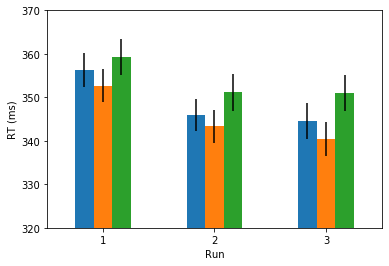

In [47]:
fig, ax1 = plt.subplots()

ind_run_RT.pivot('Run', 'Condition').plot.bar(rot=0, ax=ax1, legend=False, yerr = ind_RT_sem)
ax1.set_ylim([320, 370])
ax1.set_ylabel("RT (ms)")


In [48]:
ind_run_condition_RT = main_df.groupby(['Subject', 'Run', 'Condition'], as_index=False)['firstRT'].mean()
ind_run_condition_RT['Run'] = pd.to_numeric(ind_run_condition_RT['Run'])

ind_run_condition_RT

,Subject,Run,Condition,firstRT
0,1,1,PH,345.598592
1,1,1,RH,336.547009
2,1,1,RL,352.785235
3,1,2,PH,340.004598
4,1,2,RH,334.593220
...,...,...,...,...
274,34,2,RH,361.231481
275,34,2,RL,365.378289
276,34,3,PH,360.405868
277,34,3,RH,357.300000


In [49]:
ind_run_R_condition_RT = ind_run_condition_RT[ind_run_condition_RT.Condition != 'PH']
ind_run_R_condition_RT

,Subject,Run,Condition,firstRT
1,1,1,RH,336.547009
2,1,1,RL,352.785235
4,1,2,RH,334.593220
5,1,2,RL,347.300676
7,1,3,RH,326.241758
...,...,...,...,...
272,34,1,RL,371.062295
274,34,2,RH,361.231481
275,34,2,RL,365.378289
277,34,3,RH,357.300000


In [50]:
formula = 'firstRT ~ Condition*Run'
lm = sm.ols(formula, ind_run_R_condition_RT).fit()
print(lm.params)
lm.summary()

Intercept              357.775187
Condition[T.RL]          4.173986
Run                     -6.147421
Condition[T.RL]:Run      2.088290
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                firstRT   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     4.539
Date:                Mon, 14 Jun 2021   Prob (F-statistic):            0.00429
Time:                        17:01:22   Log-Likelihood:                -837.06
No. Observations:                 186   AIC:                             1682.
Df Residuals:                     182   BIC:                             1695.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             357.7752      6.043     59.205      0.000     345.852     369.699
Condition[T.RL]         4.1740      8.546      0.488      0.626     -12.688      21.036
Run                    -6.1474      2.797     -2.198      0.029     -11.667      -0.628
Condition[T.RL]:Run     2.0883      3.956      0.528      0.598      -5.717       9.894
==============================================================================
Omnibus:                        5.298   Durbin-Watson:                   0.328
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                3.064
Skew:                           0.071   Prob(JB):                        0.216
Kurtosis:                       2.387   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
ind_total_RT = main_df.groupby(['Subject', 'Condition'], as_index=False)['firstRT'].mean()
ind_total_RT


,Subject,Condition,firstRT
0,1,PH,337.990726
1,1,RH,332.963190
2,1,RL,348.550820
3,2,PH,354.152811
4,2,RH,351.530864
...,...,...,...
88,33,RH,344.036789
89,33,RL,352.893757
90,34,PH,366.616762
91,34,RH,362.348910


In [52]:

a_df = ind_total_RT[ind_total_RT['Condition'] == 'PH']
b_df = ind_total_RT[ind_total_RT['Condition'] == 'RH']
c_df = ind_total_RT[ind_total_RT['Condition'] == 'RL']

print('PH vs. RH RT: ', ttest_ind(a_df['firstRT'], b_df['firstRT']))
print('RH vs. RL RT: ', ttest_ind(b_df['firstRT'], c_df['firstRT']))
print('PH vs. RL RT: ', ttest_ind(a_df['firstRT'], c_df['firstRT']))


PH vs. RH RT:  Ttest_indResult(statistic=0.6509989551446306, pvalue=0.5175326633607162)
RH vs. RL RT:  Ttest_indResult(statistic=-1.5597364534997469, pvalue=0.12408168681437647)
PH vs. RL RT:  Ttest_indResult(statistic=-0.8994959148767147, pvalue=0.3719845115632061)


In [53]:
a1_df = ind_RT.loc[(ind_RT['Condition'] == 'PH') & (ind_RT['Run'] == '1')]
a2_df = ind_RT.loc[(ind_RT['Condition'] == 'PH') & (ind_RT['Run'] == '2')]
a3_df = ind_RT.loc[(ind_RT['Condition'] == 'PH') & (ind_RT['Run'] == '3')]

b1_df = ind_RT.loc[(ind_RT['Condition'] == 'RH') & (ind_RT['Run'] == '1')]
b2_df = ind_RT.loc[(ind_RT['Condition'] == 'RH') & (ind_RT['Run'] == '2')]
b3_df = ind_RT.loc[(ind_RT['Condition'] == 'RH') & (ind_RT['Run'] == '3')]

c1_df = ind_RT.loc[(ind_RT['Condition'] == 'RL') & (ind_RT['Run'] == '1')]
c2_df = ind_RT.loc[(ind_RT['Condition'] == 'RL') & (ind_RT['Run'] == '2')]
c3_df = ind_RT.loc[(ind_RT['Condition'] == 'RL') & (ind_RT['Run'] == '3')]

/home/jungtak/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [54]:
print('PH vs. RH Run1 RT: ', ttest_ind(a1_df['firstRT'], b1_df['firstRT']))
print('RH vs. RL Run1 RT: ', ttest_ind(b1_df['firstRT'], c1_df['firstRT']))
print('PH vs. RL Run1 RT: ', ttest_ind(a1_df['firstRT'], c1_df['firstRT']))
print()
print('PH vs. RH Run2 RT: ', ttest_ind(a2_df['firstRT'], b2_df['firstRT']))
print('RH vs. RL Run2 RT: ', ttest_ind(b2_df['firstRT'], c2_df['firstRT']))
print('PH vs. RL Run2 RT: ', ttest_ind(a2_df['firstRT'], c2_df['firstRT']))
print()
print('PH vs. RH Run3 RT: ', ttest_ind(a3_df['firstRT'], b3_df['firstRT']))
print('RH vs. RL Run3 RT: ', ttest_ind(b3_df['firstRT'], c3_df['firstRT']))
print('PH vs. RL Run3 RT: ', ttest_ind(a3_df['firstRT'], c3_df['firstRT']))

PH vs. RH Run1 RT:  Ttest_indResult(statistic=nan, pvalue=nan)
RH vs. RL Run1 RT:  Ttest_indResult(statistic=nan, pvalue=nan)
PH vs. RL Run1 RT:  Ttest_indResult(statistic=nan, pvalue=nan)

PH vs. RH Run2 RT:  Ttest_indResult(statistic=nan, pvalue=nan)
RH vs. RL Run2 RT:  Ttest_indResult(statistic=nan, pvalue=nan)
PH vs. RL Run2 RT:  Ttest_indResult(statistic=nan, pvalue=nan)

PH vs. RH Run3 RT:  Ttest_indResult(statistic=nan, pvalue=nan)
RH vs. RL Run3 RT:  Ttest_indResult(statistic=nan, pvalue=nan)
PH vs. RL Run3 RT:  Ttest_indResult(statistic=nan, pvalue=nan)


In [55]:
prac_ind_total_RT = prac_df.groupby(['Subject', 'Condition'], as_index=False)['firstRT'].mean()
prac_ind_total_RT

,Subject,Condition,firstRT
0,1,pracH,342.288660
1,1,pracL,344.049505
2,2,pracH,340.847059
3,2,pracL,341.950311
4,3,pracH,369.645570
...,...,...,...
57,31,pracL,363.039474
58,33,pracH,353.357143
59,33,pracL,347.826389
60,34,pracH,381.222222


In [56]:
pracH_df2 = prac_ind_total_RT[prac_ind_total_RT['Condition'] == 'pracH']
pracL_df2 = prac_ind_total_RT[prac_ind_total_RT['Condition'] == 'pracL']

print('pracH vs. pracL RT: ', ttest_ind(pracH_df2['firstRT'], pracL_df2['firstRT']))


pracH vs. pracL RT:  Ttest_indResult(statistic=0.12098913892186172, pvalue=0.9041039105072246)


In [57]:
for s in range(len(subjects)):
    sub_RT = main_df[main_df['Subject'] == subjects[s]]['firstRT']
    sub_idx = main_df[main_df['Subject'] == subjects[s]]['firstRT'].index
    main_df.loc[sub_idx, 'NormalizedRT'] = (sub_RT - sub_RT.mean()) / sub_RT.std()
main_df

,Subject,event,firstRT,firstACC,TrialType,BlocksInRun,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,RandomDelay,PatternDelay,ScaningOnset,Run,blockNum,Condition,TrialOnset,NormalizedRT
0,1,1,361,1,P,1,NaN,BlockProc,6,384208,NaN,11.0,74777,1,1,NaN,309.431,0.446649
1,1,2,356,1,R,1,NaN,BlockProc,7,384822,5.0,NaN,74777,1,1,NaN,310.045,0.335395
2,1,2,346,1,P,1,NaN,BlockProc,8,385452,NaN,15.0,74777,1,1,PH,310.675,0.112888
3,1,1,333,1,R,1,NaN,BlockProc,9,386065,8.0,NaN,74777,1,1,RL,311.288,-0.176372
4,1,3,273,1,P,1,NaN,BlockProc,10,386679,NaN,2.0,74777,1,1,PH,311.902,-1.511418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,34,4,396,1,R,12,NaN,BlockProc,81,748877,5.0,NaN,32961,3,36,RH,715.916,0.764329
89276,34,4,348,1,P,12,NaN,BlockProc,82,749507,NaN,15.0,32961,3,36,PH,716.546,-0.476349
89277,34,4,347,1,R,12,NaN,BlockProc,83,750120,8.0,NaN,32961,3,36,RL,717.159,-0.502197
89278,34,1,298,1,P,12,NaN,BlockProc,84,750733,NaN,1.0,32961,3,36,PH,717.772,-1.768722


In [58]:
for s in range(len(subjects)):
    sub_RT = prac_df[prac_df['Subject'] == subjects[s]]['firstRT']
    sub_idx = prac_df[prac_df['Subject'] == subjects[s]]['firstRT'].index
    prac_df.loc[sub_idx, 'NormalizedRT'] = (sub_RT - sub_RT.mean()) / sub_RT.std()
prac_df

/home/jungtak/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jungtak/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Subject,event,firstRT,firstACC,TrialType,BlockList.Cycle,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,DisplayLetter.OnsetDelay,DisplayBlack.OnsetDelay,Fixation1.RTTime,Condition,NormalizedRT
90185,1,1,365,1,Prac,NaN,1.0,PracBlockProc2,1,81108,11.0,NaN,74777,NaN,0.505343
90186,1,3,311,1,Prac,NaN,1.0,PracBlockProc2,2,81721,4.0,NaN,74777,NaN,-0.782148
90187,1,3,310,1,Prac,NaN,1.0,PracBlockProc2,3,82351,14.0,NaN,74777,pracL,-0.805990
90188,1,1,381,1,Prac,NaN,1.0,PracBlockProc2,4,82965,8.0,NaN,74777,pracL,0.886822
90189,1,2,327,1,Prac,NaN,1.0,PracBlockProc2,5,83578,1.0,NaN,74777,pracL,-0.400669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43685,34,1,369,1,Prac,NaN,5.0,PracBlockProc2,81,932459,6.0,NaN,636533,pracH,-0.250888
43686,34,4,427,1,Prac,NaN,5.0,PracBlockProc2,82,933073,0.0,NaN,636533,pracL,1.061212
43687,34,3,360,1,Prac,NaN,5.0,PracBlockProc2,83,933703,10.0,NaN,636533,pracL,-0.454490
43688,34,4,372,1,Prac,NaN,5.0,PracBlockProc2,84,934316,3.0,NaN,636533,pracL,-0.183021


In [59]:
ind_run_condition_RT = main_df.groupby(['Subject', 'Run', 'Condition'], as_index=False)['NormalizedRT'].mean()
ind_run_condition_RT['Run'] = pd.to_numeric(ind_run_condition_RT['Run'])

ind_run_R_condition_RT = ind_run_condition_RT[ind_run_condition_RT.Condition != 'PH']
ind_run_R_condition_RT

,Subject,Run,Condition,NormalizedRT
1,1,1,RH,-0.097449
2,1,1,RL,0.263864
4,1,2,RH,-0.140922
5,1,2,RL,0.141829
7,1,3,RH,-0.326748
...,...,...,...,...
272,34,1,RL,0.119752
274,34,2,RH,-0.134349
275,34,2,RL,-0.027165
277,34,3,RH,-0.235968


In [60]:
formula = 'NormalizedRT ~ Condition*Run'
lm = sm.ols(formula, ind_run_R_condition_RT).fit()
print(lm.params)
lm.summary()

Intercept              0.218359
Condition[T.RL]        0.102480
Run                   -0.166636
Condition[T.RL]:Run    0.057527
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           NormalizedRT   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     65.75
Date:                Mon, 14 Jun 2021   Prob (F-statistic):           7.55e-29
Time:                        17:01:23   Log-Likelihood:                 86.426
No. Observations:                 186   AIC:                            -164.9
Df Residuals:                     182   BIC:                            -151.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2184      0.042      5.178      0.000       0.135       0.302
Condition[T.RL]         0.1025      0.060      1.718      0.087      -0.015       0.220
Run                    -0.1666      0.020     -8.536      0.000      -0.205      -0.128
Condition[T.RL]:Run     0.0575      0.028      2.084      0.039       0.003       0.112
==============================================================================
Omnibus:                        2.711   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.283
Skew:                           0.233   Prob(JB):                        0.319
Kurtosis:                       3.279   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
ind_conditional_mean_RT = main_df.groupby(['Subject', 'Condition'], as_index=False)['NormalizedRT'].mean()

reshaped_conditional_df = ind_conditional_mean_RT.pivot_table(
        values='NormalizedRT', 
        index=['Subject'], 
        columns='Condition', 
        aggfunc=np.sum)
reshaped_conditional_df.head()

Condition,PH,RH,RL
Subject,,,
1,-0.065325,-0.177191,0.169645
2,-0.048509,-0.120467,0.131804
3,0.003894,-0.146301,0.072470
4,-0.030165,-0.114115,0.110100
5,-0.096301,-0.237456,0.232593


In [62]:
prac_ind_conditional_mean_RT = prac_df.groupby(['Subject', 'Condition'], as_index=False)['NormalizedRT'].mean()

prac_reshaped_conditional_df = prac_ind_conditional_mean_RT.pivot_table(
        values='NormalizedRT', 
        index=['Subject'], 
        columns='Condition', 
        aggfunc=np.sum)
prac_reshaped_conditional_df.head()

Condition,pracH,pracL
Subject,,
1,-0.036150,0.005832
2,-0.035537,0.001470
3,-0.012820,0.007533
4,0.054026,0.000091
5,0.101774,-0.011916


In [63]:
SL_mean_df = pd.DataFrame()
SL_mean_df['PatternLearning'] = reshaped_conditional_df['RH'] - reshaped_conditional_df['PH']
SL_mean_df['ProbabilityLearning'] = reshaped_conditional_df['RL'] - reshaped_conditional_df['RH']
SL_mean_df.head()

,PatternLearning,ProbabilityLearning
Subject,,
1,-0.111867,0.346837
2,-0.071958,0.252271
3,-0.150195,0.218771
4,-0.083950,0.224215
5,-0.141156,0.470049


In [64]:
prac_SL_mean_df = pd.DataFrame()
prac_SL_mean_df['ProbabilityLearning'] = prac_reshaped_conditional_df['pracL'] - prac_reshaped_conditional_df['pracH']
prac_SL_mean_df.head()

,ProbabilityLearning
Subject,
1,0.041983
2,0.037007
3,0.020352
4,-0.053936
5,-0.113690


In [65]:
scaled_SL_df = SL_mean_df['ProbabilityLearning'] - prac_SL_mean_df['ProbabilityLearning']
scaled_SL_df.head()

Subject
1    0.304854
2    0.215264
3    0.198418
4    0.278151
5    0.583740
Name: ProbabilityLearning, dtype: float64

In [66]:
print('mean SL scores vs. 0: ', stats.ttest_1samp(SL_mean_df['ProbabilityLearning'], 0))


mean SL scores vs. 0:  Ttest_1sampResult(statistic=11.206447821536415, pvalue=3.0228292296761153e-12)


In [67]:
print('mean prac_SL scores vs. 0: ', stats.ttest_1samp(prac_SL_mean_df['ProbabilityLearning'], 0))



mean prac_SL scores vs. 0:  Ttest_1sampResult(statistic=-0.762904289724389, pvalue=0.45147810835676394)


In [68]:
[datasave_dir + 'ind_SL_mean_RT.txt']

['/home/jungtak/HDD/FCSL/FCSL1/CONN_20210609/ind_SL_mean_RT.txt']

In [69]:
os.remove(datasave_dir + 'ind_SL_mean_RT.txt')
os.remove(datasave_dir + 'ind_scaled_SL_RT.txt')

SL_mean_df['ProbabilityLearning'].to_csv(datasave_dir + 'ind_SL_mean_RT.txt', header=None, index=None, sep='\t', mode='a')
scaled_SL_df.to_csv(datasave_dir + 'ind_scaled_SL_RT.txt', header=None, index=None, sep='\t', mode='a')


In [139]:
ind_block_RT = main_df.groupby(['Subject', 'blockNum', 'Condition'], as_index=False)['NormalizedRT'].mean()

reshaped_df = ind_block_RT.pivot_table(
        values='NormalizedRT', 
        index=['Subject', 'blockNum'], 
        columns='Condition', 
        aggfunc=np.sum)
reshaped_df

Condition               PH        RH        RL
Subject blockNum                              
1       1         0.062373 -0.339544  0.351289
        2        -0.052757 -0.482748  0.362703
        3         0.334810  0.310920  0.425223
        4         0.258172  0.004106  0.375776
        5         0.370162  0.508951  0.554343
...                    ...       ...       ...
34      32       -0.017937  0.483699  0.202147
        33        0.124224  0.413952 -0.034695
        34       -0.445499 -1.016274 -0.286801
        35        0.060181 -0.601894  0.288735
        36       -0.252804 -0.648665  0.030261

[1116 rows x 3 columns]

In [71]:
main_df

,Subject,event,firstRT,firstACC,TrialType,BlocksInRun,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,RandomDelay,PatternDelay,ScaningOnset,Run,blockNum,Condition,TrialOnset,NormalizedRT
0,1,1,361,1,P,1,NaN,BlockProc,6,384208,NaN,11.0,74777,1,1,NaN,309.431,0.446649
1,1,2,356,1,R,1,NaN,BlockProc,7,384822,5.0,NaN,74777,1,1,NaN,310.045,0.335395
2,1,2,346,1,P,1,NaN,BlockProc,8,385452,NaN,15.0,74777,1,1,PH,310.675,0.112888
3,1,1,333,1,R,1,NaN,BlockProc,9,386065,8.0,NaN,74777,1,1,RL,311.288,-0.176372
4,1,3,273,1,P,1,NaN,BlockProc,10,386679,NaN,2.0,74777,1,1,PH,311.902,-1.511418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,34,4,396,1,R,12,NaN,BlockProc,81,748877,5.0,NaN,32961,3,36,RH,715.916,0.764329
89276,34,4,348,1,P,12,NaN,BlockProc,82,749507,NaN,15.0,32961,3,36,PH,716.546,-0.476349
89277,34,4,347,1,R,12,NaN,BlockProc,83,750120,8.0,NaN,32961,3,36,RL,717.159,-0.502197
89278,34,1,298,1,P,12,NaN,BlockProc,84,750733,NaN,1.0,32961,3,36,PH,717.772,-1.768722


In [138]:
ind_run_RT = main_df.groupby(['Subject', 'Run', 'Condition'], as_index=False)['NormalizedRT'].mean()

reshaped_run_df = ind_run_RT.pivot_table(
        values='NormalizedRT', 
        index=['Subject', 'Run'], 
        columns='Condition', 
        aggfunc=np.sum)
reshaped_run_df

Condition          PH        RH        RL
Subject Run                              
1       1    0.103956 -0.097449  0.263864
        2   -0.020515 -0.140922  0.141829
        3   -0.276886 -0.326748  0.107828
2       1    0.347147  0.195897  0.496886
        2    0.148626  0.252324  0.256419
...               ...       ...       ...
33      2   -0.089878 -0.205475  0.074731
        3   -0.185524 -0.235443  0.028351
34      1    0.196378  0.037626  0.119752
        2   -0.026540 -0.134349 -0.027165
        3   -0.155689 -0.235968  0.027182

[93 rows x 3 columns]

In [140]:
SL_df = pd.DataFrame()
SL_df['PatternLearning'] = reshaped_df['RH'] - reshaped_df['PH']
SL_df['ProbabilityLearning'] = reshaped_df['RL'] - reshaped_df['RH']
SL_df

PatternLearning  ProbabilityLearning
Subject blockNum                                      
1       1               -0.401917             0.690833
        2               -0.429991             0.845451
        3               -0.023890             0.114303
        4               -0.254066             0.371670
        5                0.138789             0.045392
...                           ...                  ...
34      32               0.501636            -0.281553
        33               0.289728            -0.448647
        34              -0.570775             0.729473
        35              -0.662075             0.890629
        36              -0.395862             0.678926

[1116 rows x 2 columns]

In [74]:
SL_run_df = pd.DataFrame()
SL_run_df['PatternLearning'] = reshaped_run_df['RH'] - reshaped_run_df['PH']
SL_run_df['ProbabilityLearning'] = reshaped_run_df['RL'] - reshaped_run_df['RH']
SL_run_df

PatternLearning  ProbabilityLearning
Subject Run                                      
1       1          -0.201405             0.361313
        2          -0.120407             0.282751
        3          -0.049862             0.434576
2       1          -0.151250             0.300989
        2           0.103698             0.004095
...                      ...                  ...
33      2          -0.115596             0.280205
        3          -0.049919             0.263794
34      1          -0.158752             0.082126
        2          -0.107809             0.107184
        3          -0.080279             0.263150

[93 rows x 2 columns]

In [75]:
SL_run_df.reset_index(inplace=True)
SL_run_df

,Subject,Run,PatternLearning,ProbabilityLearning
0,1,1,-0.201405,0.361313
1,1,2,-0.120407,0.282751
2,1,3,-0.049862,0.434576
3,2,1,-0.151250,0.300989
4,2,2,0.103698,0.004095
...,...,...,...,...
88,33,2,-0.115596,0.280205
89,33,3,-0.049919,0.263794
90,34,1,-0.158752,0.082126
91,34,2,-0.107809,0.107184


In [76]:
SL_run_df['Run'] = SL_run_df['Run'].astype('int64')

In [141]:
SL_df.reset_index(inplace=True)
SL_df['blockNum'] = SL_df['blockNum'].astype('int64')

In [143]:
SL_df

,Subject,blockNum,PatternLearning,ProbabilityLearning
0,1,1,-0.401917,0.690833
1,1,2,-0.429991,0.845451
2,1,3,-0.023890,0.114303
3,1,4,-0.254066,0.371670
4,1,5,0.138789,0.045392
...,...,...,...,...
1111,34,32,0.501636,-0.281553
1112,34,33,0.289728,-0.448647
1113,34,34,-0.570775,0.729473
1114,34,35,-0.662075,0.890629


In [151]:
formula = 'ProbabilityLearning ~ blockNum'
lm = sm.ols(formula, SL_df).fit()
print(lm.params)


anova_lm(lm)
# lm.summary()

Intercept    0.122202
blockNum     0.005071
dtype: float64


,df,sum_sq,mean_sq,F,PR(>F)
blockNum,1.0,3.096992,3.096992,19.645702,0.00001
Residual,1114.0,175.613442,0.157642,NaN,NaN


In [150]:
formula = 'ProbabilityLearning ~ Run'
lm = sm.ols(formula, SL_run_df).fit()
print(lm.params)


anova_lm(lm)
# lm.summary()

Intercept    0.102480
Run          0.057527
dtype: float64


,df,sum_sq,mean_sq,F,PR(>F)
Run,1.0,0.205183,0.205183,11.098287,0.00125
Residual,91.0,1.682387,0.018488,NaN,NaN


In [78]:
SL_mean_block_df = SL_df.groupby(['blockNum'], as_index=False)['ProbabilityLearning'].mean()
SL_sem_block_df = SL_df.groupby(['blockNum'], as_index=False)['ProbabilityLearning'].sem()
SL_mean_block_df

,ProbabilityLearning
0,0.136684
1,0.152916
2,0.156142
3,0.039900
4,0.230907
5,0.167233
6,0.194536
7,0.129243
8,0.114120
9,0.222643


In [79]:
SL_df

PatternLearning  ProbabilityLearning
Subject blockNum                                      
1       1               -0.401917             0.690833
        2               -0.429991             0.845451
        3               -0.023890             0.114303
        4               -0.254066             0.371670
        5                0.138789             0.045392
...                           ...                  ...
34      32               0.501636            -0.281553
        33               0.289728            -0.448647
        34              -0.570775             0.729473
        35              -0.662075             0.890629
        36              -0.395862             0.678926

[1116 rows x 2 columns]

In [80]:
SL_mean_run_df = SL_run_df.groupby(['Run'], as_index=True)['ProbabilityLearning'].mean()
SL_sem_run_df = SL_run_df.groupby(['Run'], as_index=True)['ProbabilityLearning'].sem()
#SL_mean_run_df.reindex([1, 2, 3])
SL_mean_run_df

Run
1    0.166153
2    0.205244
3    0.281207
Name: ProbabilityLearning, dtype: float64

In [81]:
SL_run_df

,Subject,Run,PatternLearning,ProbabilityLearning
0,1,1,-0.201405,0.361313
1,1,2,-0.120407,0.282751
2,1,3,-0.049862,0.434576
3,2,1,-0.151250,0.300989
4,2,2,0.103698,0.004095
...,...,...,...,...
88,33,2,-0.115596,0.280205
89,33,3,-0.049919,0.263794
90,34,1,-0.158752,0.082126
91,34,2,-0.107809,0.107184


In [82]:
plt.rcParams["figure.dpi"] = 300

Text(0, 0.5, 'Normalized RT difference (a.u.)')

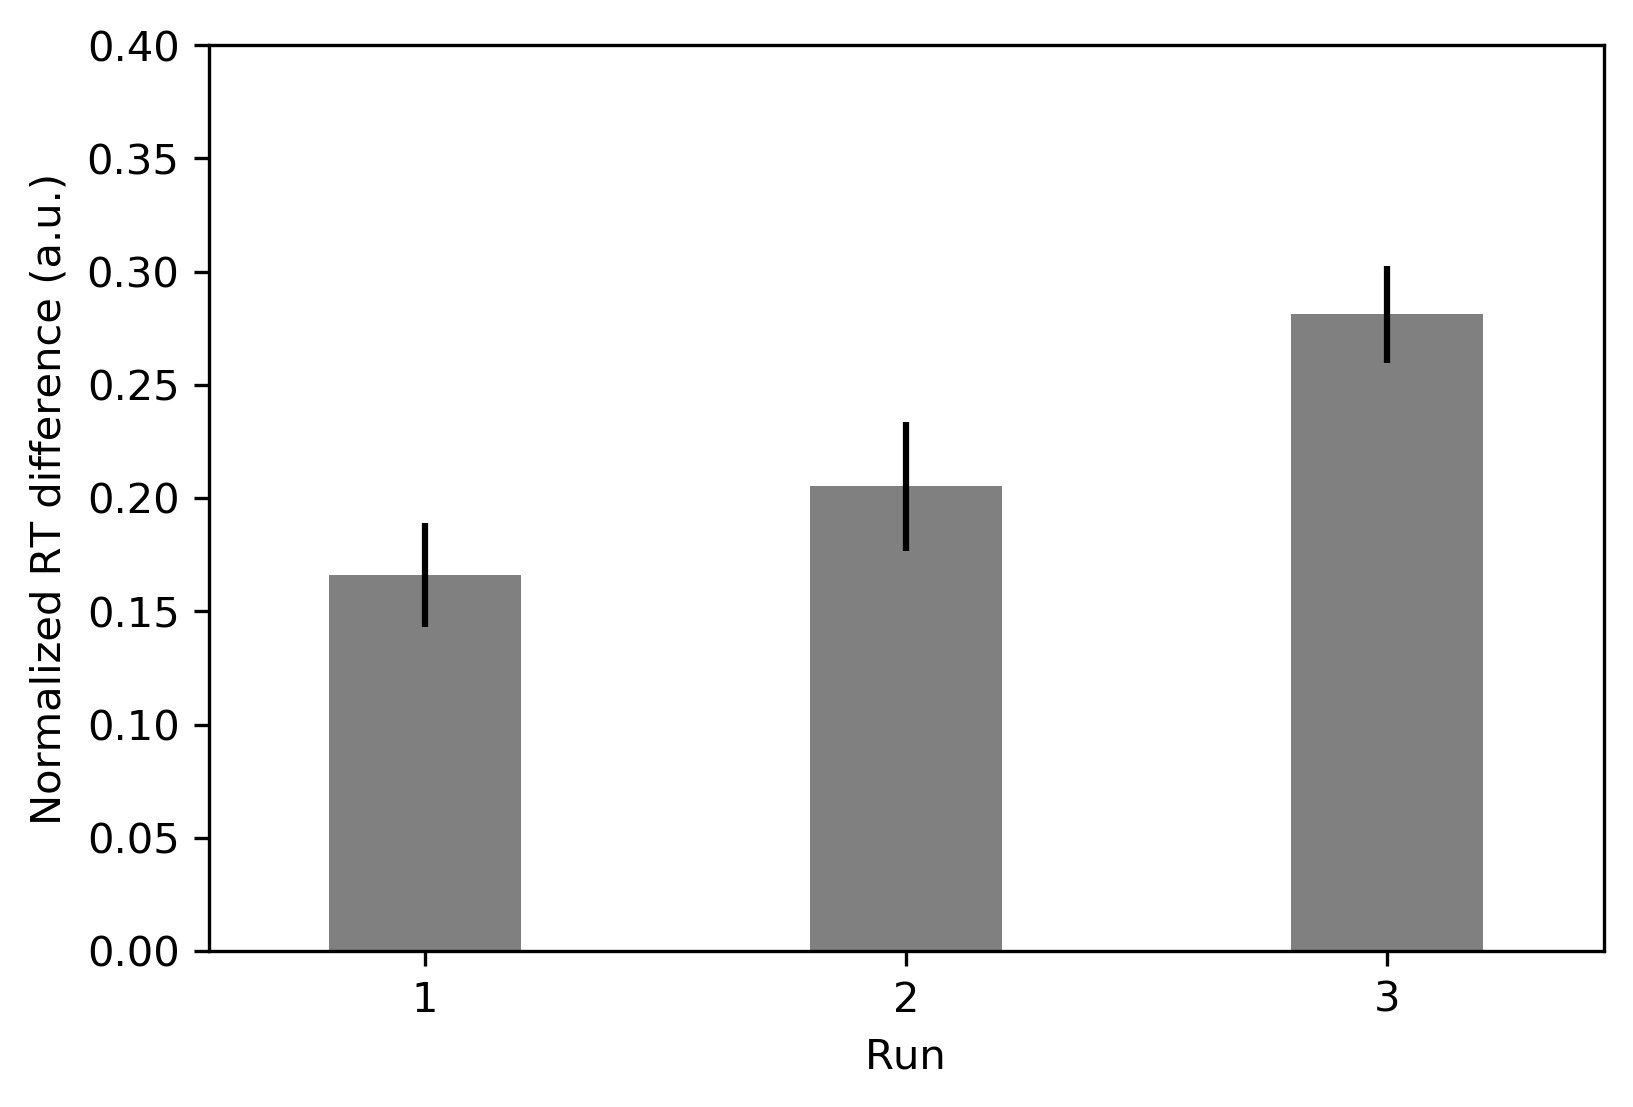

In [132]:
fig2, ax2 = plt.subplots()

SL_mean_run_df.plot.bar(rot=0, ax=ax2, legend=False, yerr = SL_sem_run_df, color="gray", width=0.4)
ax2.set_ylim([0.00, 0.40])
ax2.set_ylabel("Normalized RT difference (a.u.)")


In [84]:
SL_run_df2 = SL_run_df

In [85]:
SL_run_df2.reset_index(inplace=True)  
SL_run_df2

,index,Subject,Run,PatternLearning,ProbabilityLearning
0,0,1,1,-0.201405,0.361313
1,1,1,2,-0.120407,0.282751
2,2,1,3,-0.049862,0.434576
3,3,2,1,-0.151250,0.300989
4,4,2,2,0.103698,0.004095
...,...,...,...,...,...
88,88,33,2,-0.115596,0.280205
89,89,33,3,-0.049919,0.263794
90,90,34,1,-0.158752,0.082126
91,91,34,2,-0.107809,0.107184


In [86]:

run1_SL_df = SL_run_df2[SL_run_df2['Run'] == 1]
run2_SL_df = SL_run_df2[SL_run_df2['Run'] == 2]
run3_SL_df = SL_run_df2[SL_run_df2['Run'] == 3]


print('Run1 vs. Run2 SL scores: ', ttest_ind(run1_SL_df['ProbabilityLearning'], run2_SL_df['ProbabilityLearning']))
print('Run1 vs. Run3 SL scores: ', ttest_ind(run1_SL_df['ProbabilityLearning'], run3_SL_df['ProbabilityLearning']))
print('Run2 vs. Run3 SL scores: ', ttest_ind(run2_SL_df['ProbabilityLearning'], run3_SL_df['ProbabilityLearning']))

Run1 vs. Run2 SL scores:  Ttest_indResult(statistic=-1.0680854246853069, pvalue=0.28976055515153953)
Run1 vs. Run3 SL scores:  Ttest_indResult(statistic=-3.6657106354206346, pvalue=0.0005245129007299857)
Run2 vs. Run3 SL scores:  Ttest_indResult(statistic=-2.124675819315084, pvalue=0.03774243109536025)


In [144]:
print('Run1 vs. 0 SL scores: ', stats.ttest_1samp(run1_SL_df['ProbabilityLearning'], 0))
print('Run3 vs. 0 SL scores: ', stats.ttest_1samp(run3_SL_df['ProbabilityLearning'], 0))
print('Run2 vs. 0 SL scores: ', stats.ttest_1samp(run2_SL_df['ProbabilityLearning'], 0))

Run1 vs. 0 SL scores:  Ttest_1sampResult(statistic=7.263919754743727, pvalue=4.357596971380934e-08)
Run3 vs. 0 SL scores:  Ttest_1sampResult(statistic=13.084077933242147, pvalue=6.23876152596845e-14)
Run2 vs. 0 SL scores:  Ttest_1sampResult(statistic=7.183506012031305, pvalue=5.406826491865584e-08)


In [88]:
SL_reshaped_df = SL_df.pivot_table(
        values='ProbabilityLearning', 
        index=['Subject'], 
        columns=['blockNum'], 
        aggfunc=np.sum)

In [89]:
SL_array = SL_reshaped_df.to_numpy()
SL_array

array([[ 0.69083315,  0.84545111,  0.11430298, ...,  0.53076623,
         0.22960483,  0.55812325],
       [-0.02734862,  0.23857854,  0.19577131, ...,  0.44384505,
         0.19513421,  0.92043011],
       [ 0.57104052, -0.13245243,  0.15148634, ...,  0.5301835 ,
         0.60751517,  0.48806715],
       ...,
       [ 0.02183356,  0.1867252 ,  0.18316763, ...,  0.02899733,
        -0.20529727,  0.19143256],
       [ 0.07523232, -0.46248786,  0.52548415, ...,  0.02678254,
         0.03318706,  0.8384099 ],
       [-0.30463068,  0.21137471,  0.62613223, ...,  0.72947252,
         0.89062932,  0.67892639]])

In [90]:
print(len(SL_array), len(SL_array[0]))


31 36


In [91]:
def regressLL_linear(params):
    # Resave the initial parameter guesses
    A = params[0]
    y0 = params[1]
#     x0 = params[2]
    Sigma = params[2]

    # Calculate the predicted values from the initial parameter guesses
#     yPred = A * (x - x0) + y0
    yPred = A * (x) + y0

    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    logLik = -np.sum(stats.norm.logpdf(yObs, loc=yPred, scale=Sigma))

    # Tell the function to return the NLL (this is what will be minimized)

#     k = 4
    k = 3
    n = 31
    m = 36

#     # AIC
#     aic = 2 * k * (n/(n-k-1)) - 2 * (logLik)

#     # BIC
#     bic = k * np.log(n) -2 * logLik

#     global Tem_BIC
#     global Tem_AIC

#     Tem_AIC = aic
#     Tem_BIC = bic
    
    
    return(logLik)

In [92]:

def regressLL_power(params):
    # Resave the initial parameter guesses
    A = params[0]
    t = params[1]
#     x0 = params[2]
    Sigma = params[2]

    # Calculate the predicted values from the initial parameter guesses
    yPred = A * pow(x, t)

    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    logLik = -np.sum(stats.norm.logpdf(yObs, loc=yPred, scale=Sigma))

    # Tell the function to return the NLL (this is what will be minimized)

    k = 3
    n = 31
    m = 36

#     # AIC
#     aic = 2 * k * (n/(n-k-1)) - 2 * (logLik)

#     # BIC
#     bic = k * np.log(n) -2 * logLik
    
    
#     global Tem_BIC
#     global Tem_AIC

#     Tem_AIC = aic
#     Tem_BIC = bic


    return(logLik)

In [93]:
# Define the likelihood function where params is a list of initial parameter estimates
def regressLL_exp(params):
    # Resave the initial parameter guesses
    A = params[0]
    t = params[1]
#     x0 = params[2]
    Sigma = params[2]

    # Calculate the predicted values from the initial parameter guesses
    yPred = A * (1-np.exp(-(x)/t))

    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    logLik = -np.sum(stats.norm.logpdf(yObs, loc=yPred, scale=Sigma))

    # Tell the function to return the NLL (this is what will be minimized)

    k = 3
    n = 31
    m = 36

#     # AIC
#     aic = 2 * k * (n/(n-k-1)) - 2 * (logLik)

#     # BIC
#     bic = k * np.log(n) -2 * logLik


    return(logLik)

In [94]:
yObs = SL_array
x = []
for i in range(36):
    x = np.append(x, [i+1])
    

initParams = [1, 1, 1]
# bound = [(-500, 500), (1, 50), (0, 50), (0, 30)]
results = minimize(regressLL_exp, initParams, method='L-BFGS-B')
logLik = results.fun

k = 3
n = 31
m = 36

# AIC
aic = 2 * k * (n/(n-k-1)) - 2 * (logLik)

# BIC
bic = k * np.log(n) -2 * logLik

print()
print('AICc = ', aic)
print('BIC = ', bic)
print('LogLik = ', logLik)

print(results)


AICc =  -1105.4891555902732
BIC =  -1102.0760828657067
LogLik =  556.189022239581
      fun: 556.189022239581
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.02318154e-04,  1.13686838e-05,  1.13686838e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 25
   status: 0
  success: True
        x: array([0.26780899, 8.35926282, 0.39829542])


[0.2678089885978962, 8.359262824914927, 0.39829542180700206]


/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


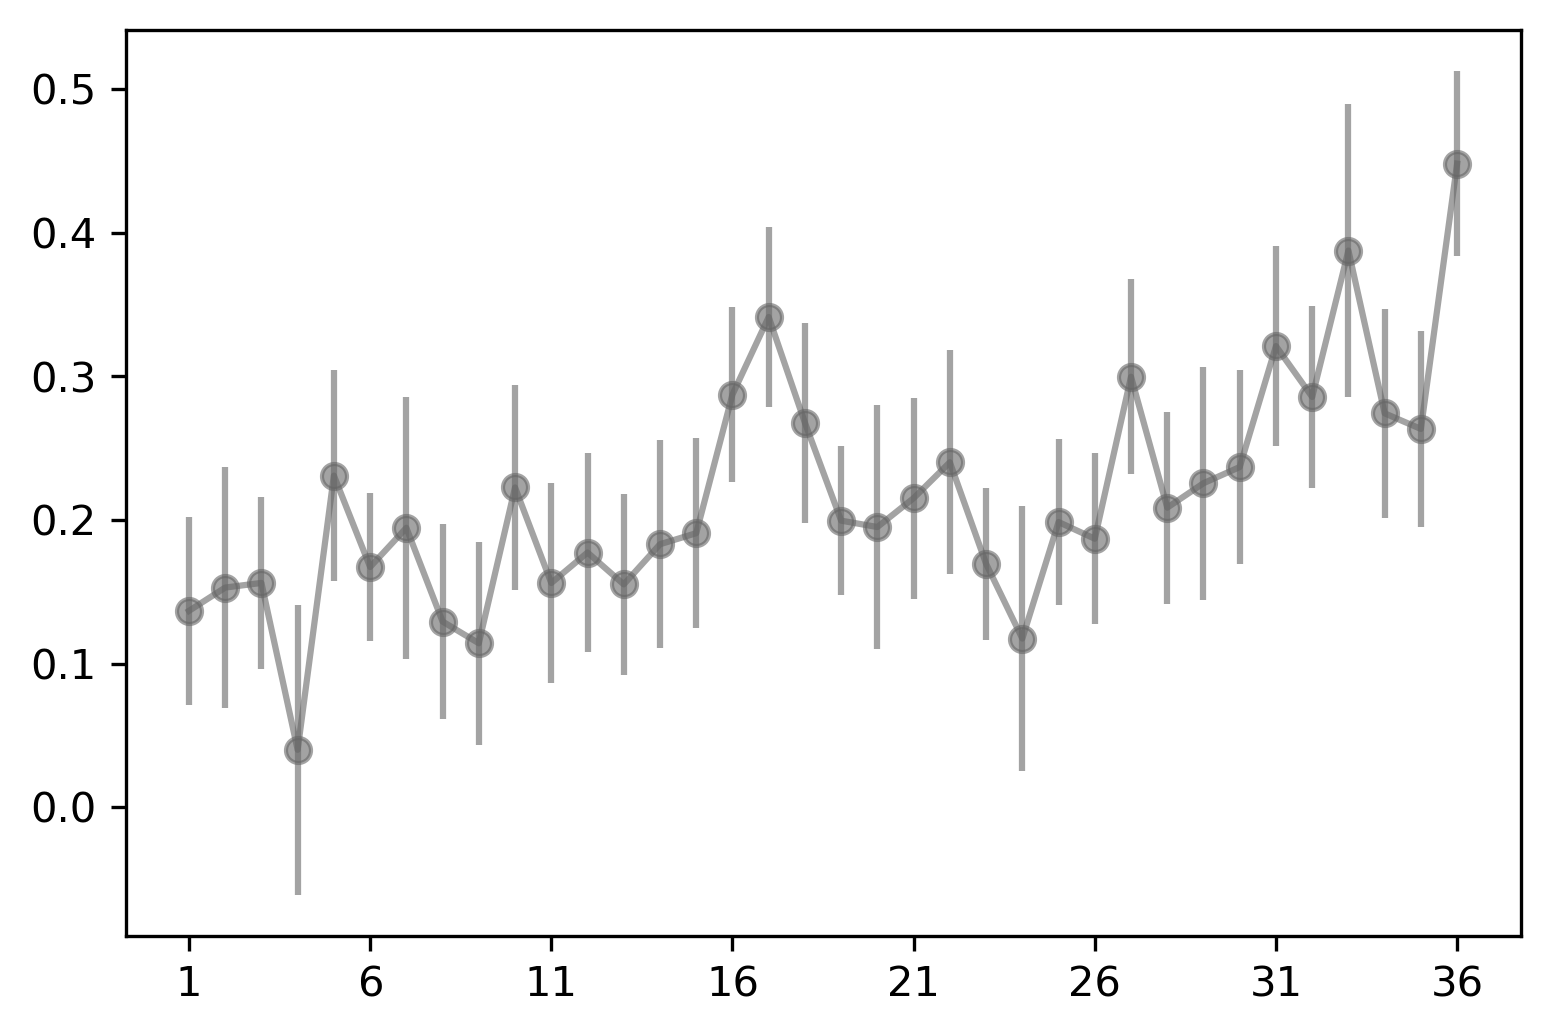

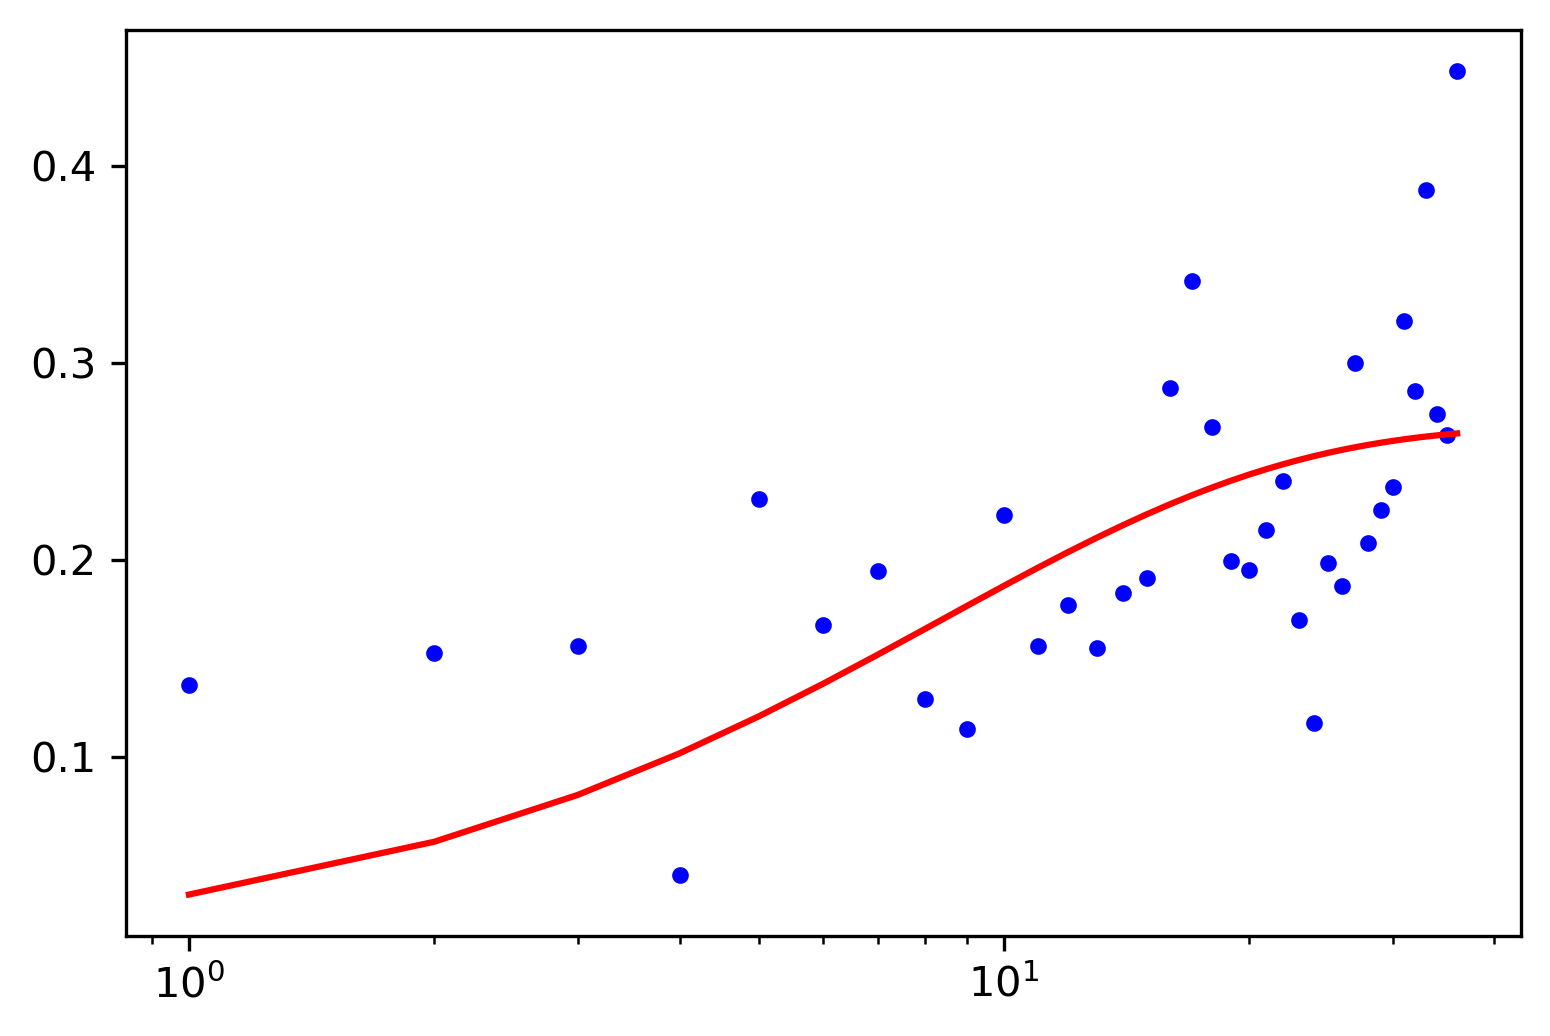

In [131]:
Params = results.x.tolist()
print(Params)

Mean_SL_RT = SL_mean_block_df.to_numpy()
SL_score_sem = SL_sem_block_df.to_numpy()


A = Params[0]
t = Params[1]

yPred = []
x = []
for i in range(len(SL_array[0])):
    x.append(i+1)
    yPred.append(A * (1-np.exp(-(x[i]) / t)))
    #yPred.append(A * (1-np.exp(-(x[i]) / t)))



fig, ax = plt.subplots()

data = ax.plot(x, Mean_SL_RT, color = (0.4, 0.4, 0.4, 0.6))
ax.errorbar(x, Mean_SL_RT, yerr=SL_score_sem, fmt='o', color=(0.4, 0.4, 0.4, 0.6), ecolor=(0.4, 0.4, 0.4, 0.6))

# fitted_Data = ax.plot(x, yPred, 'black')

width = 10 / len(SL_array[0])
chance_x = np.linspace(1 - width, len(x) + width)
chancelevel = 0 * chance_x + Params[0]
#ax.plot(chance_x, chancelevel, "r--", color='black')
ax.set_xticks([1, 6, 11, 16, 21, 26, 31, 36])

# fig.savefig('ASRT_Results/Total_MLE_SL_RT.png', bbox_inches='tight')

fig, ax = plt.subplots()

data = ax.semilogx(x, Mean_SL_RT, 'b.')
fitted_Data = ax.plot(x, yPred, 'r-')

plt.show()



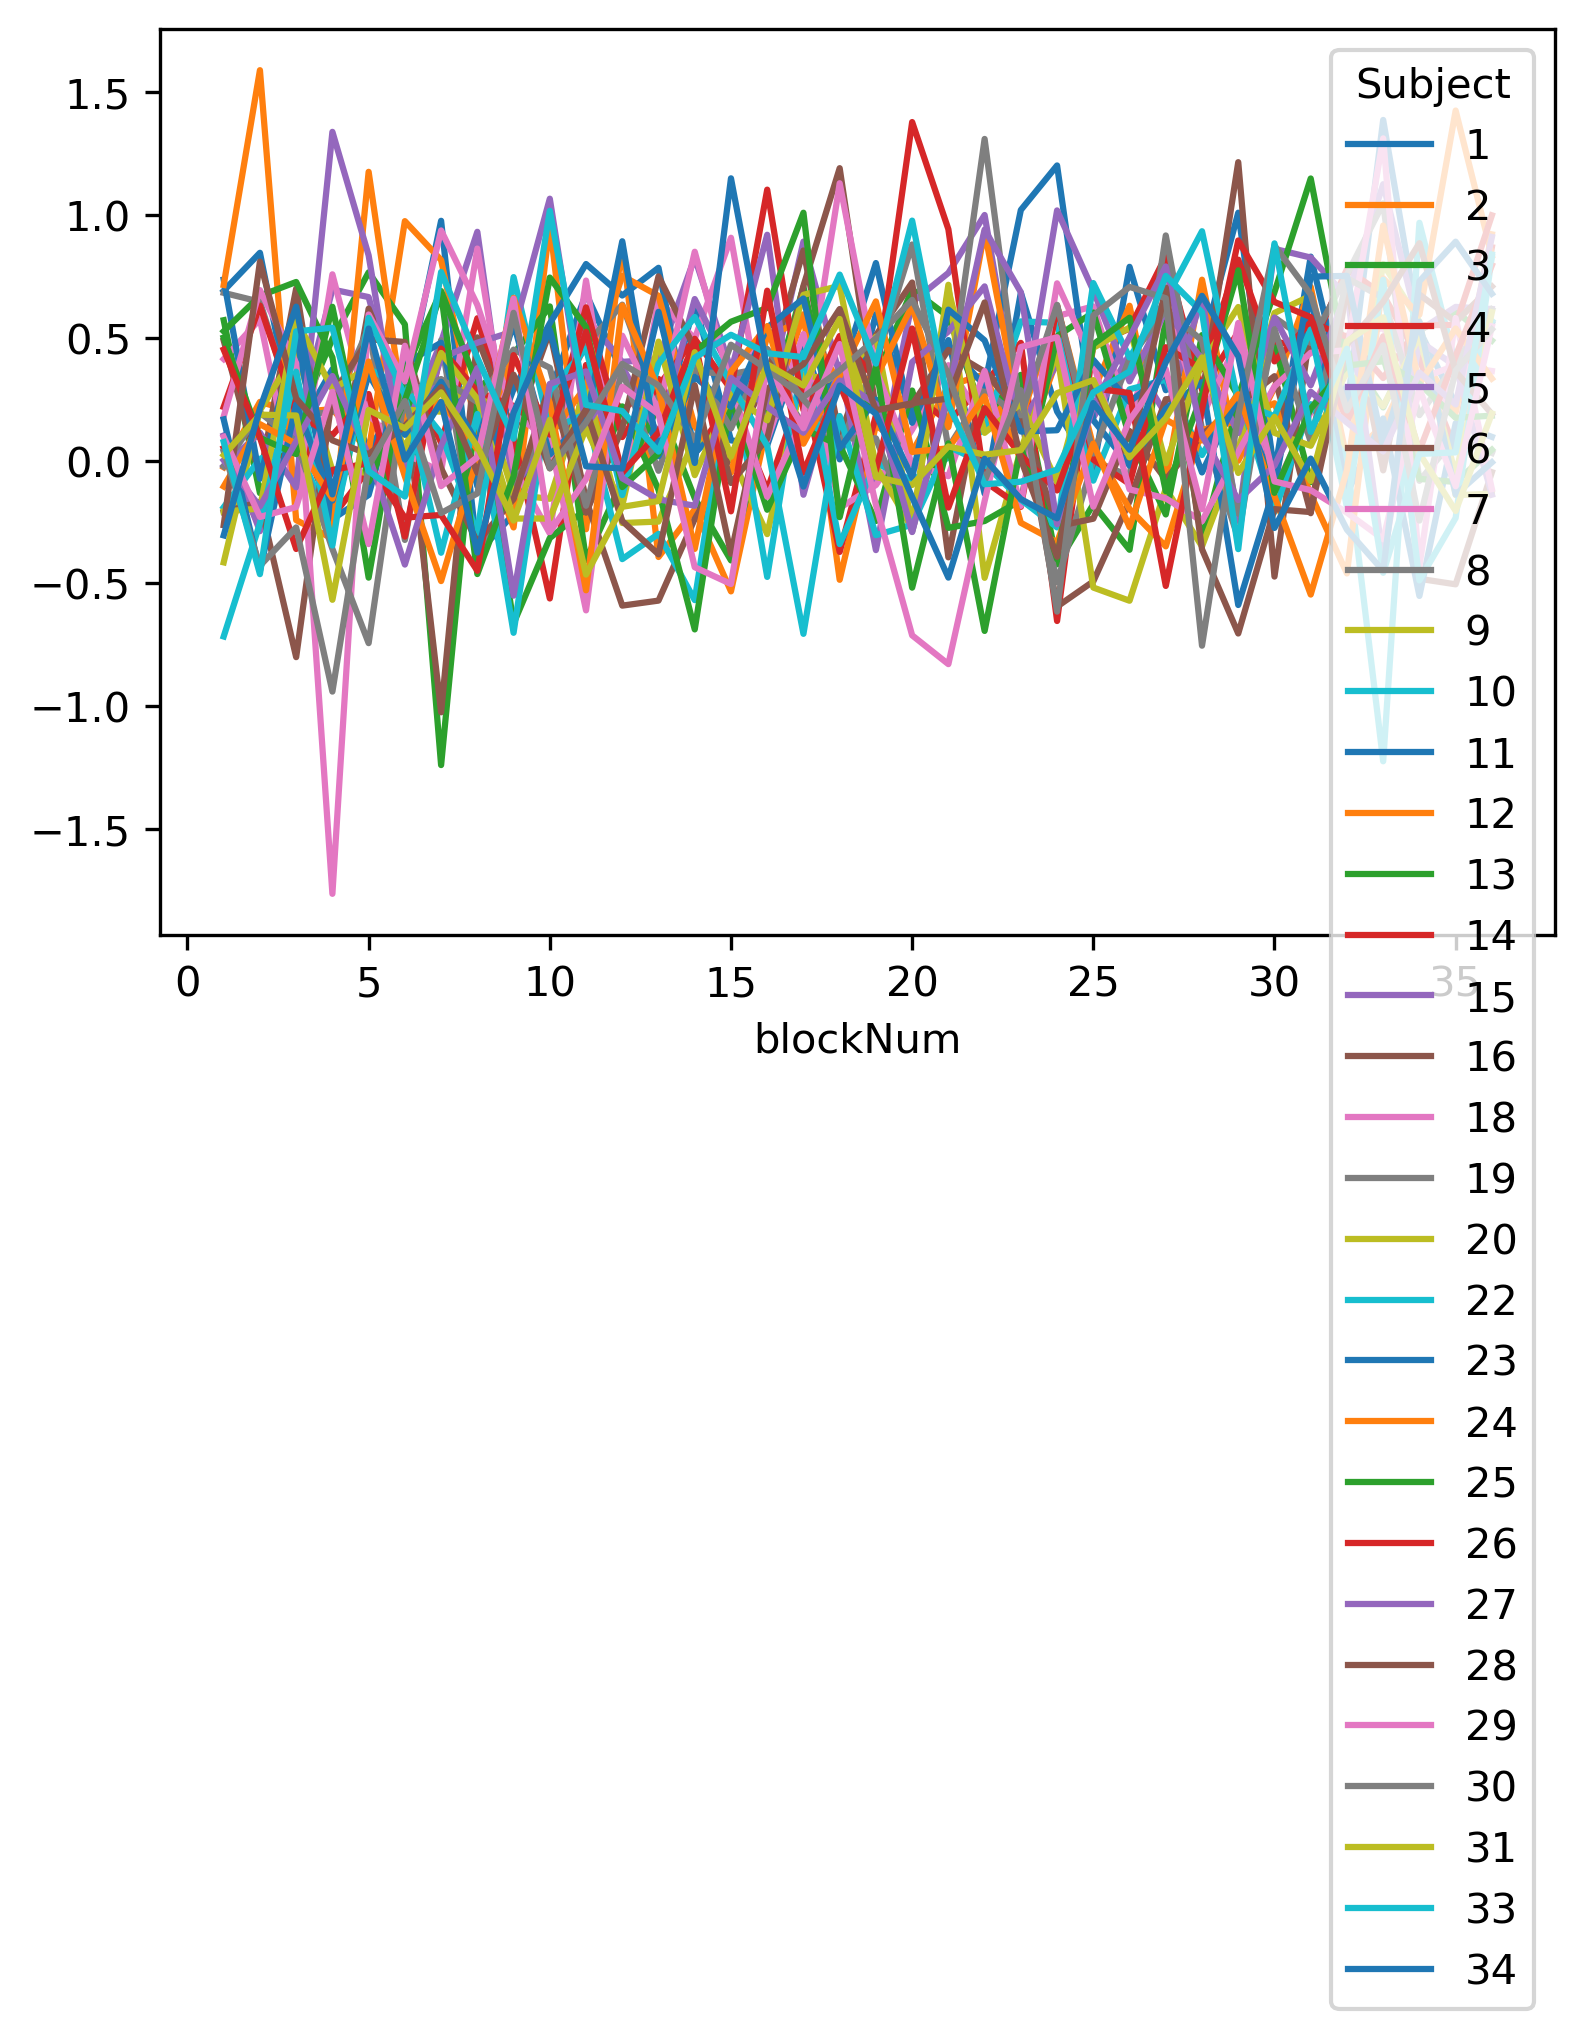

In [96]:
SL_reshaped_df.T.plot()

In [97]:
ind_exp_AIC = []
ind_exp_BIC = []
ind_exp_est_params = []
ind_linear_AIC = []
ind_linear_BIC = []
ind_linear_est_params = []
ind_power_AIC = []
ind_power_BIC = []
ind_power_est_params = []

x = []
for i in range(36):
    x = np.append(x, [i+1])

initParams_exp = [1, 1, 1]
initParams_linear = [1, 1, 1]
initParams_power = [1, 1, 1]

# bound = [(-500, 500), (1, 50), (0, 30)]

for s in range(len(SL_array)):
    yObs = SL_array[s]

    results_exp = minimize(regressLL_exp, initParams_exp, method='L-BFGS-B')
    results_linear = minimize(regressLL_linear, initParams_linear, method='L-BFGS-B')
    results_power = minimize(regressLL_power, initParams_power, method='L-BFGS-B')
    
    logLik_exp = results_exp.fun
    logLik_linear = results_linear.fun
    logLik_power = results_power.fun
    
    k = 3
    n = 31
    m = 36

    # AIC
    aic_exp = 2 * k * (n/(n-k-1)) - 2 * (-logLik_exp)
    aic_linear = 2 * k * (n/(n-k-1)) - 2 * (-logLik_linear)
    aic_power = 2 * k * (n/(n-k-1)) - 2 * (-logLik_power)

    # BIC
    bic_exp = k * np.log(n) -2 * -logLik_exp
    bic_linear = k * np.log(n) -2 * -logLik_linear
    bic_power = k * np.log(n) -2 * -logLik_power

    
    ind_exp_AIC.append(aic_exp)
    ind_linear_AIC.append(aic_linear)
    ind_power_AIC.append(aic_power)
    
    ind_exp_BIC.append(bic_exp)
    ind_linear_BIC.append(bic_linear)
    ind_power_BIC.append(bic_power)
    
    Params_exp = results_exp.x.tolist()
    Params_linear = results_linear.x.tolist()
    Params_power = results_power.x.tolist()
    
    ind_exp_est_params.append(Params_exp)
    ind_linear_est_params.append(Params_linear)
    ind_power_est_params.append(Params_power)
    
    
#     print()
#     print('AICc = ', aic)
#     print('BIC = ', bic)
#     print('LogLik = ', logLik)
#     print('Params = ', Params)

/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


In [98]:
ind_model_AIC = {'exp_AIC': ind_exp_AIC, 'linear_AIC':ind_linear_AIC, 'power_AIC':ind_power_AIC}
model_df = pd.DataFrame(ind_model_AIC)
model_df

,exp_AIC,linear_AIC,power_AIC
0,NaN,NaN,NaN
1,43.239079,42.894124,NaN
2,NaN,47.698023,NaN
3,NaN,23.615082,22.924733
4,29.168742,NaN,NaN
5,NaN,59.063930,NaN
6,NaN,NaN,NaN
7,NaN,NaN,36.366366
8,NaN,36.113116,NaN
9,NaN,44.015136,NaN


In [99]:
-(model_df['exp_AIC']) + (model_df['linear_AIC'])

0          NaN
1    -0.344955
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15    0.118489
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22   -0.286586
23   -0.418153
24   -0.202517
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
dtype: float64

[-0.08945241629059099, 1.0269715522282383, 0.6020033577291649]


/home/jungtak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


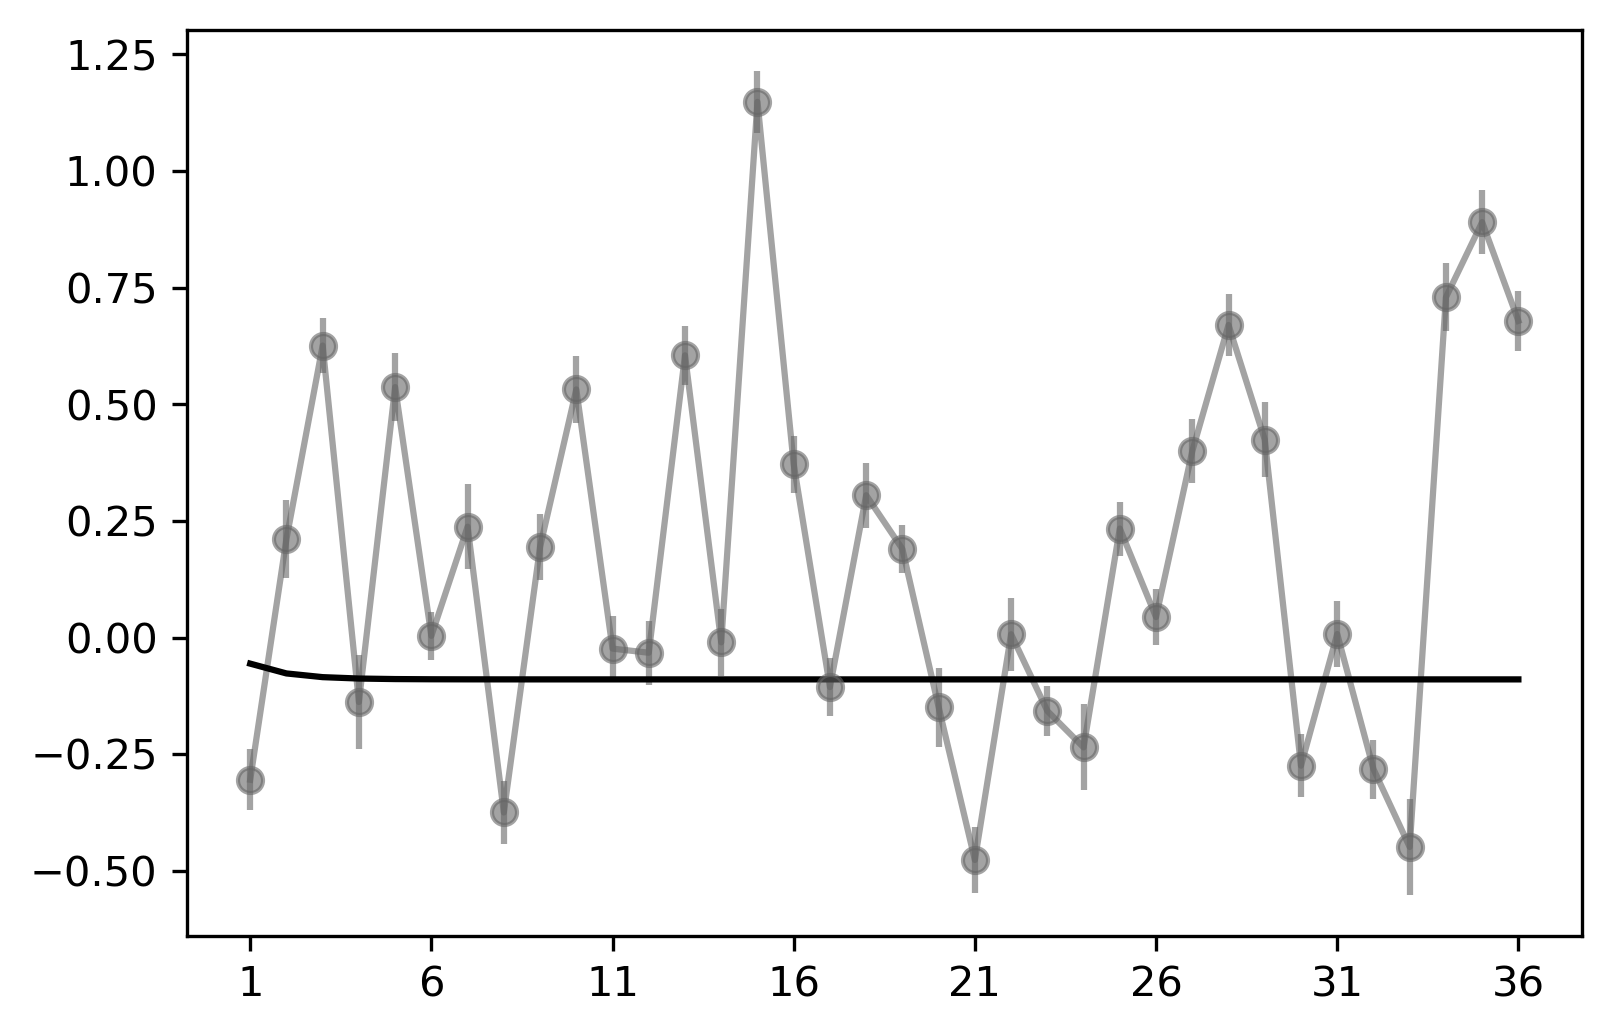

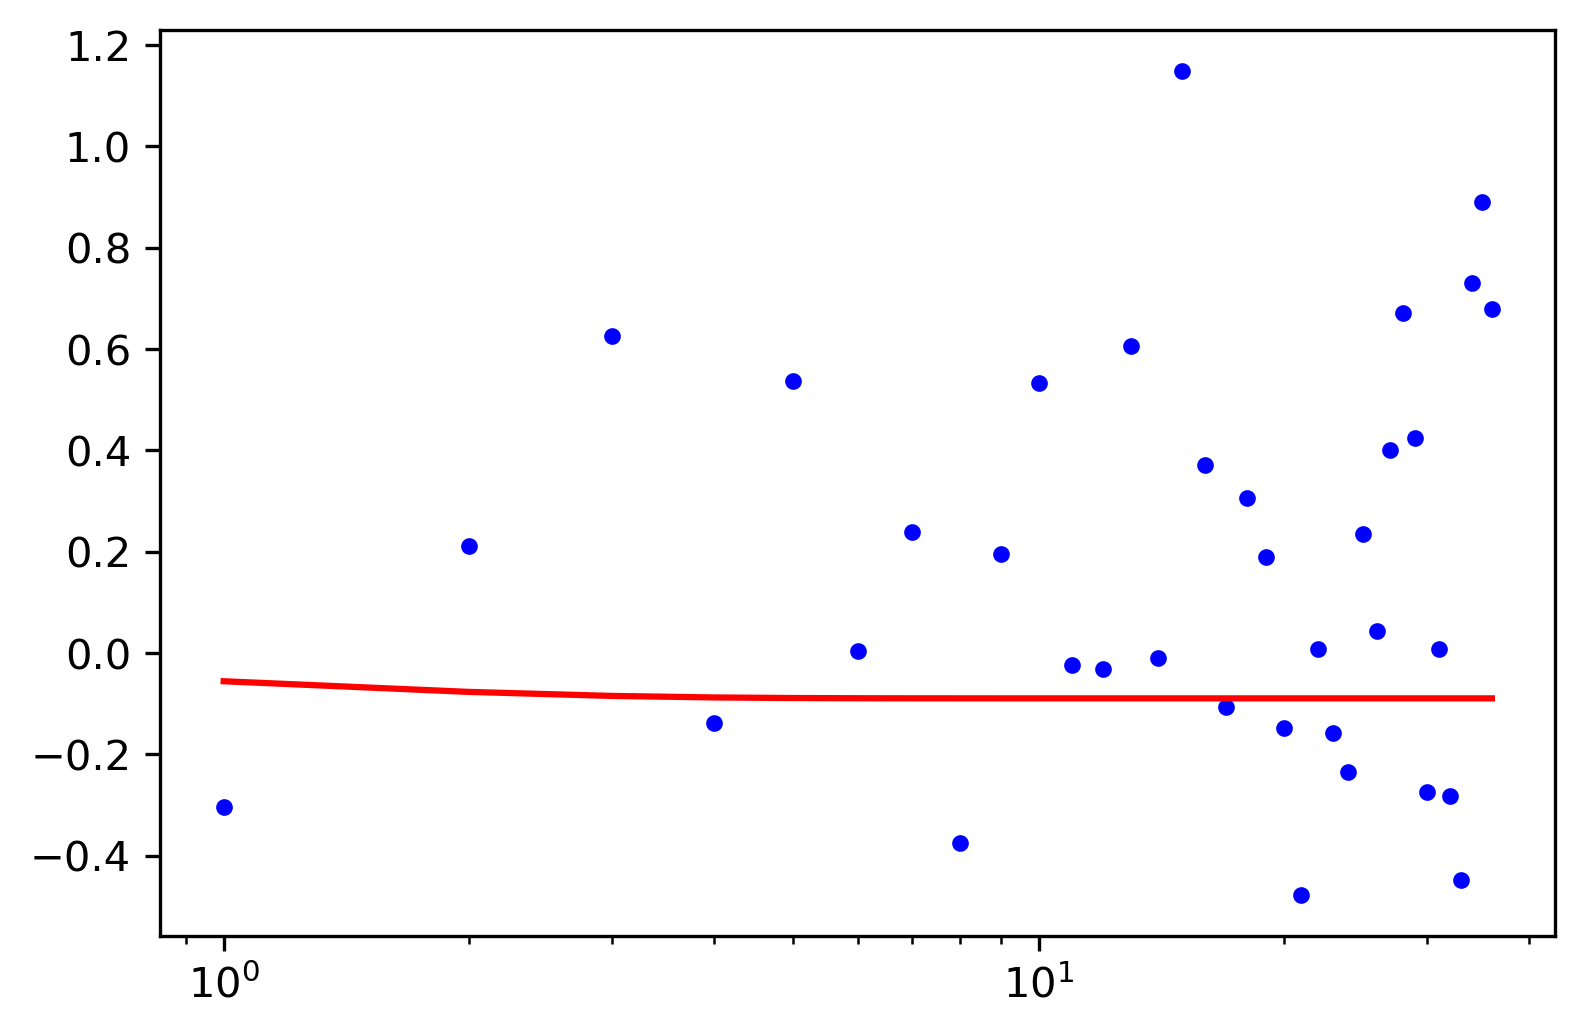

In [100]:
Params = results_exp.x.tolist()
print(Params)

SL_tem = SL_reshaped_df.to_numpy()
Mean_SL_RT = SL_tem[-1]


A = Params[0]
t = Params[1]
# x0 = Params[2]

yPred = []
x = []
for i in range(len(SL_array[0])):
    x.append(i+1)
#     yPred.append(A * (1-np.exp(-(x[i]-x0) / t)))
    yPred.append(A * (1-np.exp(-(x[i]) / t)))



fig, ax = plt.subplots()

data = ax.plot(x, Mean_SL_RT, color = (0.4, 0.4, 0.4, 0.6))
ax.errorbar(x, Mean_SL_RT, yerr=SL_score_sem, fmt='o', color=(0.4, 0.4, 0.4, 0.6), ecolor=(0.4, 0.4, 0.4, 0.6))

fitted_Data = ax.plot(x, yPred, 'black')

width = 10 / len(SL_array[0])
chance_x = np.linspace(1 - width, len(x) + width)
chancelevel = 0 * chance_x + Params[0]
#ax.plot(chance_x, chancelevel, "r--", color='black')
ax.set_xticks([1, 6, 11, 16, 21, 26, 31, 36])

# fig.savefig('ASRT_Results/Total_MLE_SL_RT.png', bbox_inches='tight')

fig, ax = plt.subplots()

data = ax.semilogx(x, Mean_SL_RT, 'b.')
fitted_Data = ax.plot(x, yPred, 'r-')

plt.show()




In [101]:
for s in range(len(subjects)):
    SL_df.query('Subject == '+str(subjects[s])).mean()

In [102]:
    SL_df.query('Subject == '+str(subjects[s]))

PatternLearning  ProbabilityLearning
Subject blockNum                                      
34      1                0.567605            -0.304631
        2               -0.186348             0.211375
        3               -0.309451             0.626132
        4               -0.345748            -0.137949
        5               -0.931985             0.537053
        6               -0.574921             0.003877
        7                0.230873             0.237846
        8               -0.214509            -0.374694
        9               -0.163365             0.194392
        10              -0.450120             0.532070
        11              -0.075976            -0.023498
        12              -0.080861            -0.032309
        13              -0.650617             0.605200
        14               0.248203            -0.009963
        15              -0.707084             1.148473
        16              -0.385958             0.371557
        17               0.156239            -0.105936
        18              -0.441153             0.305267
        19              -0.337664             0.190016
        20               0.101851            -0.148807
        21               0.246248            -0.476512
        22              -0.338804             0.007290
        23               0.297437            -0.157099
        24               0.337794            -0.235212
        25              -0.409867             0.233905
        26               0.115480             0.044119
        27               0.122960             0.399641
        28              -0.057185             0.670196
        29              -0.288883             0.424398
        30               0.302784            -0.274475
        31               0.069188             0.007795
        32               0.501636            -0.281553
        33               0.289728            -0.448647
        34              -0.570775             0.729473
        35              -0.662075             0.890629
        36              -0.395862             0.678926

In [103]:
df_idx = main_df.index
main_df.loc[df_idx, 'BlocksInTotal'] = main_df['BlocksInRun'].astype('int64') + (main_df['Run'].astype('int64')-1)*12
main_df

,Subject,event,firstRT,firstACC,TrialType,BlocksInRun,PracBlockList2.Cycle,Procedure[Trial],SubTrial,firstON,RandomDelay,PatternDelay,ScaningOnset,Run,blockNum,Condition,TrialOnset,NormalizedRT,BlocksInTotal
0,1,1,361,1,P,1,NaN,BlockProc,6,384208,NaN,11.0,74777,1,1,NaN,309.431,0.446649,1
1,1,2,356,1,R,1,NaN,BlockProc,7,384822,5.0,NaN,74777,1,1,NaN,310.045,0.335395,1
2,1,2,346,1,P,1,NaN,BlockProc,8,385452,NaN,15.0,74777,1,1,PH,310.675,0.112888,1
3,1,1,333,1,R,1,NaN,BlockProc,9,386065,8.0,NaN,74777,1,1,RL,311.288,-0.176372,1
4,1,3,273,1,P,1,NaN,BlockProc,10,386679,NaN,2.0,74777,1,1,PH,311.902,-1.511418,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,34,4,396,1,R,12,NaN,BlockProc,81,748877,5.0,NaN,32961,3,36,RH,715.916,0.764329,36
89276,34,4,348,1,P,12,NaN,BlockProc,82,749507,NaN,15.0,32961,3,36,PH,716.546,-0.476349,36
89277,34,4,347,1,R,12,NaN,BlockProc,83,750120,8.0,NaN,32961,3,36,RL,717.159,-0.502197,36
89278,34,1,298,1,P,12,NaN,BlockProc,84,750733,NaN,1.0,32961,3,36,PH,717.772,-1.768722,36


In [104]:
ind_RT_df = main_df.groupby(['Subject', 'BlocksInTotal', 'Condition'], as_index=False)['NormalizedRT'].mean()
ind_RT_df

,Subject,BlocksInTotal,Condition,NormalizedRT
0,1,1,PH,0.062373
1,1,1,RH,-0.339544
2,1,1,RL,0.351289
3,1,2,PH,-0.052757
4,1,2,RH,-0.482748
...,...,...,...,...
3343,34,35,RH,-0.601894
3344,34,35,RL,0.288735
3345,34,36,PH,-0.252804
3346,34,36,RH,-0.648665


In [105]:
ind_RT_re_df = ind_RT_df.pivot_table(values='NormalizedRT',
                                    index=['Subject', 'BlocksInTotal'],
                                    columns='Condition',
                                    aggfunc=np.sum)
ind_RT_re_df

Condition                    PH        RH        RL
Subject BlocksInTotal                              
1       1              0.062373 -0.339544  0.351289
        2             -0.052757 -0.482748  0.362703
        3              0.334810  0.310920  0.425223
        4              0.258172  0.004106  0.375776
        5              0.370162  0.508951  0.554343
...                         ...       ...       ...
34      32            -0.017937  0.483699  0.202147
        33             0.124224  0.413952 -0.034695
        34            -0.445499 -1.016274 -0.286801
        35             0.060181 -0.601894  0.288735
        36            -0.252804 -0.648665  0.030261

[1116 rows x 3 columns]

In [106]:

SL_block_df = pd.DataFrame()
SL_block_df['PatternLearning'] = ind_RT_re_df['RH'] - ind_RT_re_df['PH']
SL_block_df['ProbabilityLearning'] = ind_RT_re_df['RL'] - ind_RT_re_df['RH']
SL_block_df

PatternLearning  ProbabilityLearning
Subject BlocksInTotal                                      
1       1                    -0.401917             0.690833
        2                    -0.429991             0.845451
        3                    -0.023890             0.114303
        4                    -0.254066             0.371670
        5                     0.138789             0.045392
...                                ...                  ...
34      32                    0.501636            -0.281553
        33                    0.289728            -0.448647
        34                   -0.570775             0.729473
        35                   -0.662075             0.890629
        36                   -0.395862             0.678926

[1116 rows x 2 columns]

In [107]:
re_SL_block_df = SL_block_df.pivot_table(values='ProbabilityLearning', index='Subject', columns='BlocksInTotal', aggfunc=np.sum)
re_SL_block_df.head()

BlocksInTotal,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
Subject,,,,,,,,,,,,,,,,,,,,,
1,0.690833,0.845451,0.114303,0.371670,0.045392,0.268729,0.975610,-0.378793,-0.217975,0.276651,...,0.286226,0.458922,1.008620,-0.049811,0.829786,0.212206,1.386007,0.530766,0.229605,0.558123
2,-0.027349,0.238579,0.195771,0.209265,0.037367,0.974188,0.816149,0.113463,-0.272413,0.962684,...,-0.082542,0.735921,-0.000980,0.297316,0.706996,0.003541,0.144033,0.443845,0.195134,0.920430
3,0.571041,-0.132452,0.151486,0.494395,0.765823,0.554068,-1.239493,0.284920,0.433580,0.627122,...,0.579217,-0.324743,0.232424,0.475445,-0.088067,0.445596,0.215976,0.530184,0.607515,0.488067
4,0.050784,-0.273113,0.157460,-0.230291,-0.034203,0.382480,0.072600,0.578981,0.094569,-0.561532,...,0.831828,0.287596,0.522758,0.485329,0.453092,0.778691,0.674735,0.410997,0.042186,0.867800
5,0.101746,-0.287611,0.130053,0.695978,0.665189,0.122543,0.482457,0.930859,-0.118384,0.128546,...,0.188664,0.663898,-0.245406,0.861322,0.826101,0.665974,1.124552,0.528994,0.625121,0.616565


In [108]:
scaled_SL_block_df = pd.DataFrame()

for i in range(36):
    scaled_SL_block_df[i+1] = re_SL_block_df[i+1] - prac_SL_mean_df['ProbabilityLearning']

scaled_SL_block_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
Subject,,,,,,,,,,,,,,,,,,,,,
1,0.648850,0.803468,0.072320,0.329687,0.003409,0.226746,0.933627,-0.420776,-0.259958,0.234668,...,0.244243,0.416939,0.966637,-0.091794,0.787803,0.170224,1.344024,0.488783,0.187622,0.516140
2,-0.064356,0.201571,0.158764,0.172258,0.000360,0.937181,0.779142,0.076456,-0.309420,0.925677,...,-0.119549,0.698914,-0.037987,0.260309,0.669989,-0.033466,0.107026,0.406838,0.158127,0.883423
3,0.550688,-0.152805,0.131134,0.474043,0.745471,0.533716,-1.259846,0.264567,0.413228,0.606769,...,0.558864,-0.345095,0.212072,0.455093,-0.108419,0.425244,0.195623,0.509831,0.587163,0.467715
4,0.104720,-0.219178,0.211396,-0.176355,0.019733,0.436416,0.126536,0.632916,0.148505,-0.507596,...,0.885764,0.341531,0.576694,0.539265,0.507028,0.832626,0.728670,0.464932,0.096122,0.921736
5,0.215436,-0.173921,0.243743,0.809668,0.778879,0.236233,0.596147,1.044549,-0.004694,0.242236,...,0.302354,0.777588,-0.131716,0.975012,0.939791,0.779664,1.238242,0.642684,0.738811,0.730255


In [109]:
tem_block_SL_df = pd.concat([prac_SL_mean_df['ProbabilityLearning'], re_SL_block_df], axis=1)
diff_block_SL_df = tem_block_SL_df.diff(axis=1)

diff_block_SL_df = diff_block_SL_df.drop('ProbabilityLearning', axis=1)
diff_block_SL_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
Subject,,,,,,,,,,,,,,,,,,,,,
1,0.648850,0.154618,-0.731148,0.257367,-0.326279,0.223337,0.706881,-1.354403,0.160818,0.494626,...,-0.502087,0.172696,0.549698,-1.058431,0.879598,-0.617580,1.173801,-0.855241,-0.301161,0.328518
2,-0.064356,0.265927,-0.042807,0.013494,-0.171898,0.936821,-0.158038,-0.702686,-0.385876,1.235097,...,-0.712395,0.818463,-0.736901,0.298296,0.409680,-0.703455,0.140492,0.299812,-0.248711,0.725296
3,0.550688,-0.703493,0.283939,0.342909,0.271428,-0.211755,-1.793562,1.524413,0.148661,0.193541,...,0.942389,-0.903960,0.557167,0.243021,-0.563512,0.533663,-0.229620,0.314208,0.077332,-0.119448
4,0.104720,-0.323897,0.430573,-0.387750,0.196088,0.416683,-0.309880,0.506380,-0.484411,-0.656101,...,0.294884,-0.544232,0.235162,-0.037429,-0.032237,0.325599,-0.103956,-0.263738,-0.368810,0.825614
5,0.215436,-0.389357,0.417665,0.565925,-0.030790,-0.542646,0.359914,0.448402,-1.049243,0.246929,...,-0.242780,0.475234,-0.909304,1.106728,-0.035221,-0.160127,0.458578,-0.595558,0.096127,-0.008557


In [110]:




os.remove(datasave_dir + 'ind_block_SL_score.txt')
os.remove(datasave_dir + 'ind_scaled_block_SL_score.txt')
os.remove(datasave_dir + 'ind_diff_block_SL_score.txt')


re_SL_block_df.to_csv(datasave_dir + 'ind_block_SL_score.txt', header=None, index=None, sep='\t', mode='a')
scaled_SL_block_df.to_csv(datasave_dir + 'ind_scaled_block_SL_score.txt', header=None, index=None, sep='\t', mode='a')
diff_block_SL_df.to_csv(datasave_dir + 'ind_diff_block_SL_score.txt', header=None, index=None, sep='\t', mode='a')


In [111]:
zero_data = np.zeros(shape=(len(subjects),3))
d = pd.DataFrame(zero_data)
d.head()

,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [112]:
block_SL_cov_df = pd.DataFrame()
for blocknum in range(36):
    tem_df = pd.concat([re_SL_block_df[blocknum+1]]*30, axis=1)
    block_SL_cov_df = pd.concat([block_SL_cov_df, tem_df], axis=1)
block_SL_cov_df = pd.concat([d, block_SL_cov_df], axis=1)

block_SL_cov_df.head()


,0,1,2,1,1,1,1,1,1,1,...,36,36,36,36,36,36,36,36,36,36
0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.690833,0.690833,0.690833,0.690833,0.690833,0.690833,0.690833,...,0.558123,0.558123,0.558123,0.558123,0.558123,0.558123,0.558123,0.558123,0.558123,0.558123
2,0.0,0.0,0.0,-0.027349,-0.027349,-0.027349,-0.027349,-0.027349,-0.027349,-0.027349,...,0.920430,0.920430,0.920430,0.920430,0.920430,0.920430,0.920430,0.920430,0.920430,0.920430
3,0.0,0.0,0.0,0.571041,0.571041,0.571041,0.571041,0.571041,0.571041,0.571041,...,0.488067,0.488067,0.488067,0.488067,0.488067,0.488067,0.488067,0.488067,0.488067,0.488067
4,0.0,0.0,0.0,0.050784,0.050784,0.050784,0.050784,0.050784,0.050784,0.050784,...,0.867800,0.867800,0.867800,0.867800,0.867800,0.867800,0.867800,0.867800,0.867800,0.867800


In [113]:


ind_block_RT = main_df.groupby(['Subject', 'Run', 'Condition'], as_index=False)['NormalizedRT'].mean()

reshaped_df = ind_block_RT.pivot_table(
        values='NormalizedRT', 
        index=['Subject', 'Run'], 
        columns='Condition', 
        aggfunc=np.sum)
reshaped_df



Condition          PH        RH        RL
Subject Run                              
1       1    0.103956 -0.097449  0.263864
        2   -0.020515 -0.140922  0.141829
        3   -0.276886 -0.326748  0.107828
2       1    0.347147  0.195897  0.496886
        2    0.148626  0.252324  0.256419
...               ...       ...       ...
33      2   -0.089878 -0.205475  0.074731
        3   -0.185524 -0.235443  0.028351
34      1    0.196378  0.037626  0.119752
        2   -0.026540 -0.134349 -0.027165
        3   -0.155689 -0.235968  0.027182

[93 rows x 3 columns]

In [114]:

SL_df = pd.DataFrame()
SL_df['PatternLearning'] = reshaped_df['RH'] - reshaped_df['PH']
SL_df['ProbabilityLearning'] = reshaped_df['RL'] - reshaped_df['RH']
SL_df

PatternLearning  ProbabilityLearning
Subject Run                                      
1       1          -0.201405             0.361313
        2          -0.120407             0.282751
        3          -0.049862             0.434576
2       1          -0.151250             0.300989
        2           0.103698             0.004095
...                      ...                  ...
33      2          -0.115596             0.280205
        3          -0.049919             0.263794
34      1          -0.158752             0.082126
        2          -0.107809             0.107184
        3          -0.080279             0.263150

[93 rows x 2 columns]

In [115]:
re_SL_df = SL_df.pivot_table(values='ProbabilityLearning', index='Subject', columns='Run', aggfunc=np.sum)
re_SL_df.head()

Run,1,2,3
Subject,,,
1,0.361313,0.282751,0.434576
2,0.300989,0.004095,0.395974
3,0.194844,0.189114,0.208429
4,0.052055,0.082724,0.514584
5,0.323812,0.506555,0.513512


In [116]:
prac_SL_mean_df['ProbabilityLearning'].head()

Subject
1    0.041983
2    0.037007
3    0.020352
4   -0.053936
5   -0.113690
Name: ProbabilityLearning, dtype: float64

In [117]:
scaled_run_SL_df = pd.DataFrame()
scaled_run_SL_df[1] = re_SL_df[1] - prac_SL_mean_df['ProbabilityLearning']
scaled_run_SL_df[2] = re_SL_df[2] - prac_SL_mean_df['ProbabilityLearning']
scaled_run_SL_df[3] = re_SL_df[3] - prac_SL_mean_df['ProbabilityLearning']
scaled_run_SL_df.head()

,1,2,3
Subject,,,
1,0.319330,0.240768,0.392593
2,0.263981,-0.032912,0.358966
3,0.174492,0.168762,0.188077
4,0.105991,0.136659,0.568520
5,0.437502,0.620245,0.627202


In [118]:
os.remove(datasave_dir + 'ind_SL_score_run1.txt')
os.remove(datasave_dir + 'ind_SL_score_run2.txt')
os.remove(datasave_dir + 'ind_SL_score_run3.txt')

os.remove(datasave_dir + 'ind_scaled_SL_score_run1.txt')
os.remove(datasave_dir + 'ind_scaled_SL_score_run2.txt')
os.remove(datasave_dir + 'ind_scaled_SL_score_run3.txt')

re_SL_df[1].to_csv(datasave_dir + 'ind_SL_score_run1.txt', header=None, index=None, sep='\t', mode='a')
re_SL_df[2].to_csv(datasave_dir + 'ind_SL_score_run2.txt', header=None, index=None, sep='\t', mode='a')
re_SL_df[3].to_csv(datasave_dir + 'ind_SL_score_run3.txt', header=None, index=None, sep='\t', mode='a')

scaled_run_SL_df[1].to_csv(datasave_dir + 'ind_scaled_SL_score_run1.txt', header=None, index=None, sep='\t', mode='a')
scaled_run_SL_df[2].to_csv(datasave_dir + 'ind_scaled_SL_score_run2.txt', header=None, index=None, sep='\t', mode='a')
scaled_run_SL_df[3].to_csv(datasave_dir + 'ind_scaled_SL_score_run3.txt', header=None, index=None, sep='\t', mode='a')

In [119]:
sorted_early_SL_df = re_SL_df.sort_values(by=1, ascending=False)
sorted_early_SL_df

Run,1,2,3
Subject,,,
12,0.447487,0.402827,0.258277
15,0.406972,0.408656,0.315161
1,0.361313,0.282751,0.434576
5,0.323812,0.506555,0.513512
11,0.310283,0.462560,0.114937
2,0.300989,0.004095,0.395974
8,0.282647,0.207358,0.313558
7,0.273508,0.309259,0.373033
33,0.267087,0.280205,0.263794


In [120]:
sorted_mean_SL_df = SL_mean_df.sort_values(by="ProbabilityLearning", ascending=False)
sorted_mean_SL_df

,PatternLearning,ProbabilityLearning
Subject,,
5,-0.141156,0.470049
15,-0.144955,0.380629
14,-0.198711,0.380413
12,-0.155034,0.359955
1,-0.111867,0.346837
11,-0.187726,0.339509
7,-0.181872,0.321478
23,-0.034054,0.284794
33,-0.120467,0.278466


In [121]:
top15_SL = sorted_mean_SL_df.head(15)
top15_SL.index

Int64Index([5, 15, 14, 12, 1, 11, 7, 23, 33, 18, 8, 2, 19, 27, 4], dtype='int64', name='Subject')

In [122]:
below15_SL = sorted_mean_SL_df.tail(16)
below15_SL.index

Int64Index([3, 25, 30, 26, 20, 16, 34, 6, 28, 22, 13, 24, 31, 9, 10, 29], dtype='int64', name='Subject')

In [123]:
NP_df = pd.read_csv('NP_tests_scores.csv', index_col=None, header=0, encoding = "ISO-8859-1")
NP_df

,subnum,COWAT1_1,COWAT1_2,COWAT1,COWAT2_1,COWAT2_2,COWAT2_3,COWAT2,CST_F,CST_B,CBT_F,CBT_B,WCST,ANT
0,1,20,18,19.0,12,11,12,11.666667,16,15,9,7,7,0.317364
1,2,23,18,20.5,21,20,20,20.333333,13,20,8,6,5,0.166151
2,3,16,6,11.0,9,10,8,9.000000,10,12,6,6,8,0.307645
3,4,22,18,20.0,8,14,11,11.000000,12,20,7,6,11,0.171612
4,5,20,21,20.5,14,10,19,14.333333,14,14,4,6,6,0.220352
5,6,20,22,21.0,20,17,26,21.000000,18,20,7,5,8,0.202694
6,7,21,14,17.5,10,12,12,11.333333,10,12,6,5,8,0.267277
7,8,19,24,21.5,25,14,18,19.000000,10,14,7,8,6,0.122370
8,9,10,11,10.5,14,15,12,13.666667,17,12,7,4,9,0.186135
9,10,16,16,16.0,20,16,17,17.666667,12,14,6,7,7,0.217922


In [124]:
SL_mean_df2 = SL_mean_df['ProbabilityLearning'].reset_index()
SL_mean_df2

,Subject,ProbabilityLearning
0,1,0.346837
1,2,0.252271
2,3,0.218771
3,4,0.224215
4,5,0.470049
5,6,0.135815
6,7,0.321478
7,8,0.269481
8,9,0.073247
9,10,0.066172


In [125]:

NP_SL_df = NP_df.drop('subnum', axis=1)
NP_SL_df['SL_score'] = SL_mean_df2['ProbabilityLearning']
NP_SL_df

,COWAT1_1,COWAT1_2,COWAT1,COWAT2_1,COWAT2_2,COWAT2_3,COWAT2,CST_F,CST_B,CBT_F,CBT_B,WCST,ANT,SL_score
0,20,18,19.0,12,11,12,11.666667,16,15,9,7,7,0.317364,0.346837
1,23,18,20.5,21,20,20,20.333333,13,20,8,6,5,0.166151,0.252271
2,16,6,11.0,9,10,8,9.000000,10,12,6,6,8,0.307645,0.218771
3,22,18,20.0,8,14,11,11.000000,12,20,7,6,11,0.171612,0.224215
4,20,21,20.5,14,10,19,14.333333,14,14,4,6,6,0.220352,0.470049
5,20,22,21.0,20,17,26,21.000000,18,20,7,5,8,0.202694,0.135815
6,21,14,17.5,10,12,12,11.333333,10,12,6,5,8,0.267277,0.321478
7,19,24,21.5,25,14,18,19.000000,10,14,7,8,6,0.122370,0.269481
8,10,11,10.5,14,15,12,13.666667,17,12,7,4,9,0.186135,0.073247
9,16,16,16.0,20,16,17,17.666667,12,14,6,7,7,0.217922,0.066172


In [126]:
NP_SL_df.corr(method='pearson')

,COWAT1_1,COWAT1_2,COWAT1,COWAT2_1,COWAT2_2,COWAT2_3,COWAT2,CST_F,CST_B,CBT_F,CBT_B,WCST,ANT,SL_score
COWAT1_1,1.000000,0.571461,0.859185,0.217211,0.393559,0.413736,0.399617,0.094602,0.175272,-0.030285,0.000553,-0.113128,0.029800,0.114910
COWAT1_2,0.571461,1.000000,0.910878,0.495533,0.438825,0.557236,0.594752,0.190751,0.314802,-0.144418,0.097393,-0.200905,-0.102139,0.010187
COWAT1,0.859185,0.910878,1.000000,0.418197,0.471520,0.555497,0.571788,0.166507,0.284420,-0.105275,0.061003,-0.182154,-0.048698,0.064138
COWAT2_1,0.217211,0.495533,0.418197,1.000000,0.544744,0.601927,0.867529,0.108288,0.176254,0.043063,0.155735,-0.207990,-0.263122,-0.307996
COWAT2_2,0.393559,0.438825,0.471520,0.544744,1.000000,0.525992,0.795072,0.068417,0.138609,0.195802,-0.025870,0.120464,-0.326843,-0.484859
COWAT2_3,0.413736,0.557236,0.555497,0.601927,0.525992,1.000000,0.853659,0.172360,0.193845,-0.159277,-0.119025,-0.080890,-0.099127,-0.272610
COWAT2,0.399617,0.594752,0.571788,0.867529,0.795072,0.853659,1.000000,0.141491,0.203766,0.019728,0.009248,-0.082149,-0.266538,-0.411731
CST_F,0.094602,0.190751,0.166507,0.108288,0.068417,0.172360,0.141491,1.000000,0.520889,0.059437,-0.136210,-0.334778,0.142789,-0.055206
CST_B,0.175272,0.314802,0.284420,0.176254,0.138609,0.193845,0.203766,0.520889,1.000000,0.079847,-0.012867,-0.422291,0.120572,0.056069
CBT_F,-0.030285,-0.144418,-0.105275,0.043063,0.195802,-0.159277,0.019728,0.059437,0.079847,1.000000,0.110185,0.227087,-0.222682,0.105052


In [127]:
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})

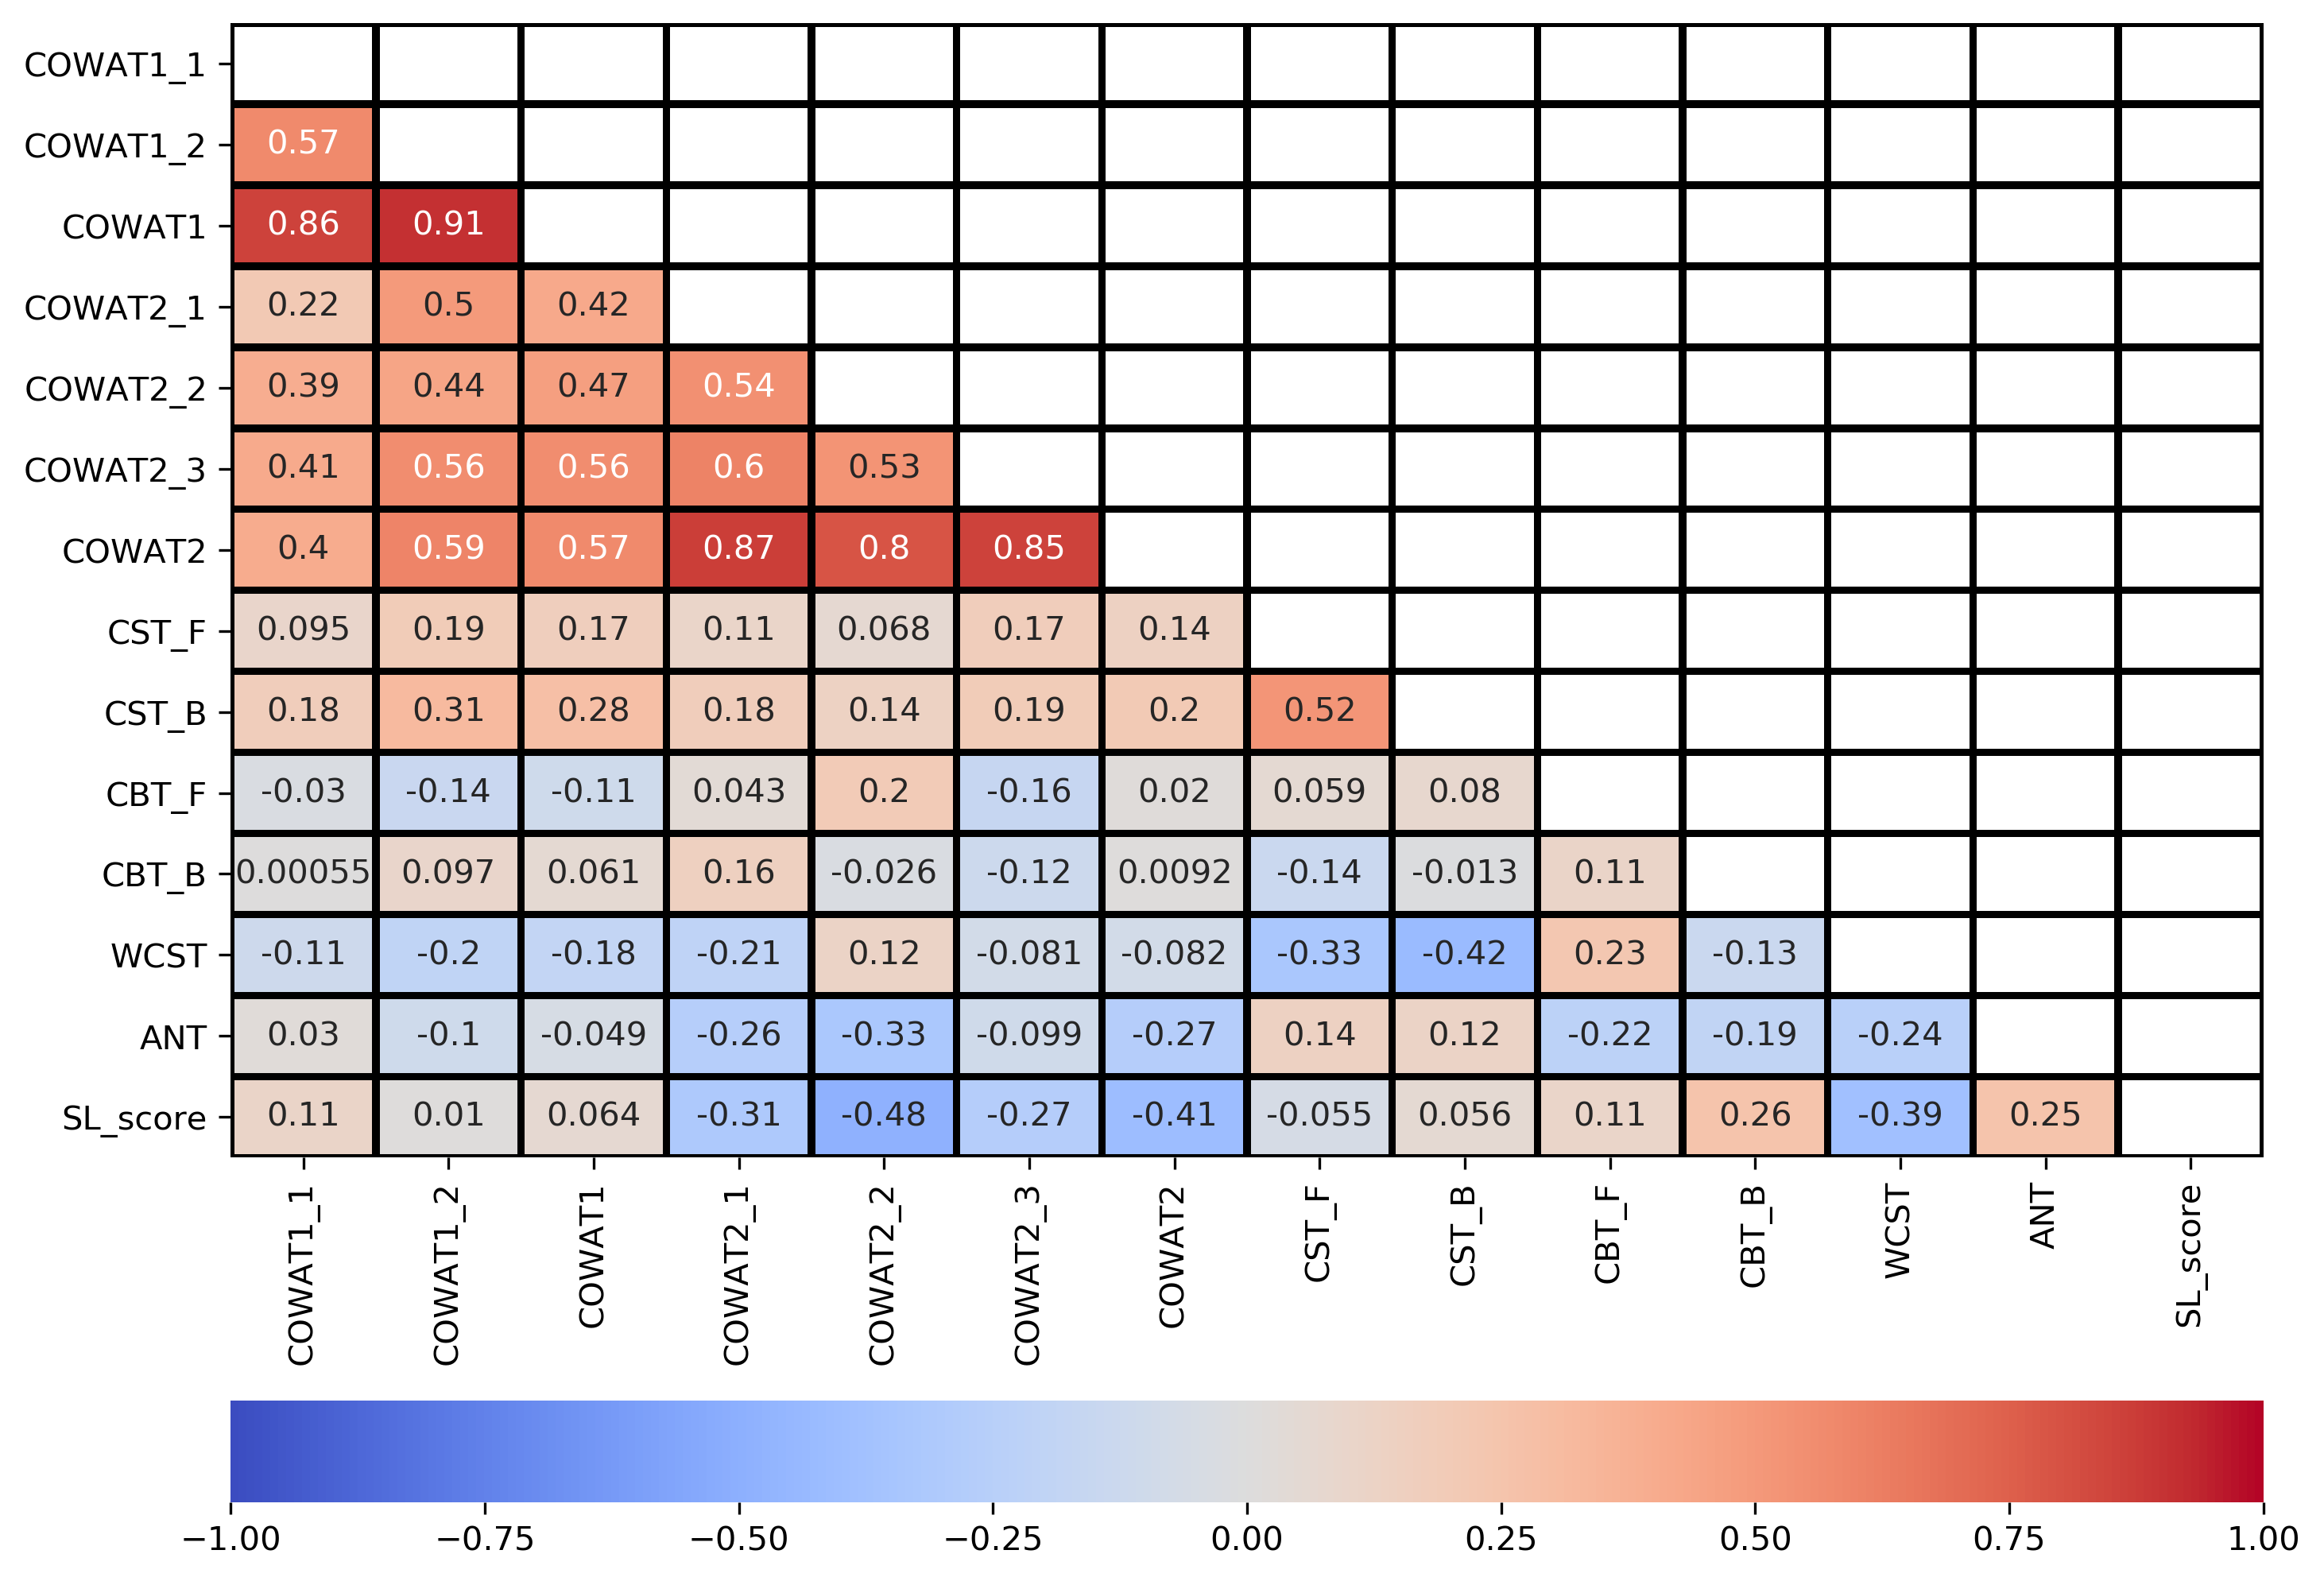

In [128]:
# Plotting without significance filtering
corr = NP_SL_df.corr(method='pearson')
mask = np.triu(corr)
plot_cor_matrix(corr,mask)
plt.show()

In [129]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix


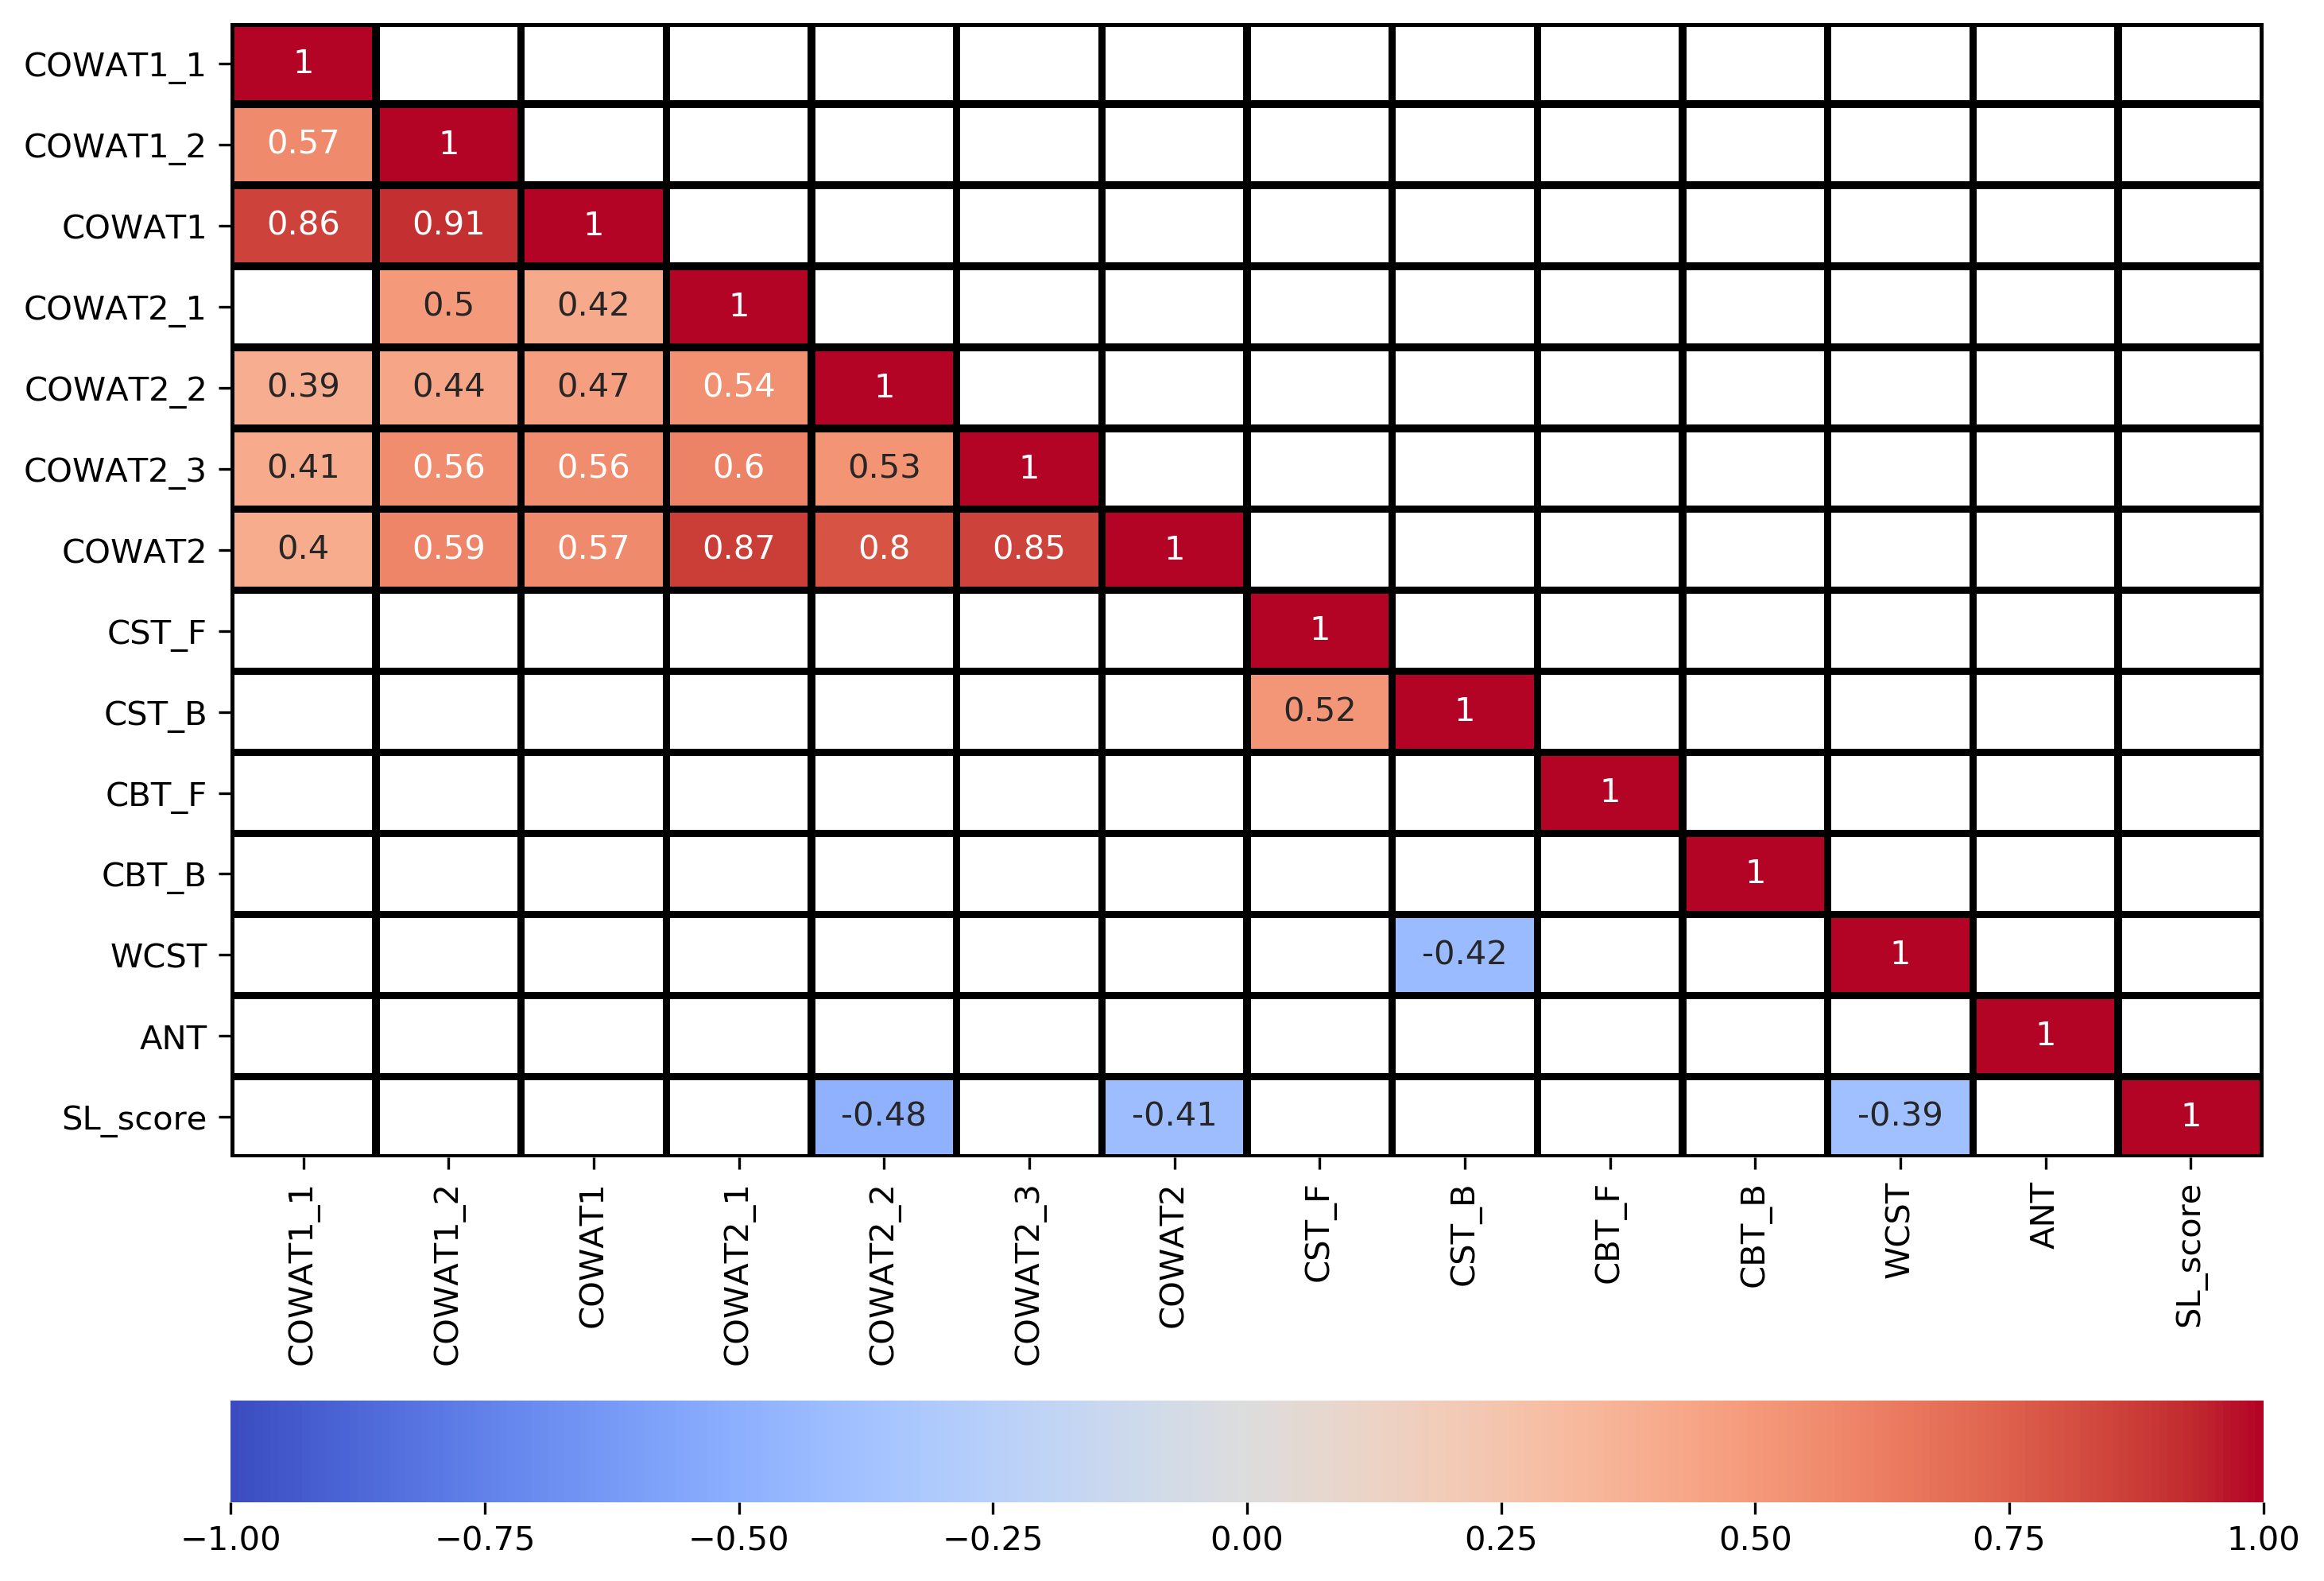

In [130]:
# Plotting with significance filter
corr = NP_SL_df.corr(method='pearson')      # get correlation
p_values = corr_sig(NP_SL_df)                     # get p-Value
mask = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr
plot_cor_matrix(corr,mask)  